Data: https://drive.google.com/drive/folders/1Sb64UJXsOZOT-h1_9RZnKgvJ470QDjeS?usp=sharing
```
/project:

   |--- /bronze_data (add startind files download here)

   |--- /silver_data (didn't used)

   |--- /golden_data (final results sholud be here)
```

In [ ]:
!pip install pyspark

In [ ]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import lit, col, min, max, count, sum
from pyspark.sql.functions import to_date, to_timestamp, date_format

from pyspark.sql.functions import lower, upper, trim, split, concat_ws, lpad, regexp_replace
from pyspark.sql.functions import when, udf, countDistinct

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
spark = SparkSession.builder.appName("CrimeData").getOrCreate()
# spark = SparkSession.builder.master("local[*]").appName("CrimeData").getOrCreate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
detroit_file = "/content/drive/MyDrive/big_data_project/bronze_data/RMS_Crime_Incidents.csv"
los_angeles_file = "/content/drive/MyDrive/big_data_project/bronze_data/Crime_Data_from_2020_to_Present_20241127.csv"
new_york_file = "/content/drive/MyDrive/big_data_project/bronze_data/NYPD_Complaint_Data_Historic_20241127.csv"
new_york_file_2 = "/content/drive/MyDrive/big_data_project/bronze_data/NYPD_Complaint_Data_Current__Year_To_Date__20241206.csv"
san_francisco_file = "/content/drive/MyDrive/big_data_project/bronze_data/Police_Department_Incident_Reports__2018_to_Present_20241127.csv"


file_paths = {
    "detroit_file" : detroit_file,
    "los_angeles_file" : los_angeles_file,
    "new_york_file" : new_york_file,
    "new_york_file_2" : new_york_file_2,
    "san_francisco_file" : san_francisco_file
}

In [ ]:
raw_file_dfs = {}
filtered_file_dfs = {}


for city, path in file_paths.items():
    print(f"City {city} is read")
    raw_file_dfs[city] = spark.read.csv(path, header=True, inferSchema=True)

City detroit_file is read
City los_angeles_file is read
City new_york_file is read
City new_york_file_2 is read
City san_francisco_file is read


In [ ]:
def normalise_date(df, report_time_name, occured_time_name, datetime_format, filter_time="2020-01-01"):
    '''
    Swap Incident Datetime and Report Datetime, where Incident Datetime < Report Datetime
    Filter data by date 2020-01-01
    '''


    result = df.filter(to_timestamp(col(report_time_name), datetime_format) < to_timestamp(col(occured_time_name), datetime_format))
    result.show(truncate=False)
    result.count()


    swapped_result = df.withColumn(
        report_time_name,
        when(
            to_timestamp(col(report_time_name), datetime_format) < to_timestamp(col(occured_time_name), datetime_format),
            col(occured_time_name)  # Swap Report Datetime with Incident Datetime
        ).otherwise(col(report_time_name))  # Keep the original value
    ).withColumn(
        occured_time_name,
        when(
            to_timestamp(col(report_time_name), datetime_format) < to_timestamp(col(occured_time_name), datetime_format),
            col(report_time_name)  # Swap Incident Datetime with Report Datetime
        ).otherwise(col(occured_time_name))  # Keep the original value
    )

    swapped_result.show(truncate=False)
    row_count = swapped_result.count()
    print(f"Total rows after swapping: {row_count}")

    result = swapped_result.filter(to_timestamp(col(report_time_name), datetime_format) < to_timestamp(col(occured_time_name), datetime_format) )
    result.show(truncate=False)
    result.count()

    return swapped_result.filter(to_timestamp(col(occured_time_name), datetime_format) >= filter_time)

In [ ]:
raw_file_dfs["detroit_file"].printSchema()


filtered_file_dfs["detroit_file"] = raw_file_dfs["detroit_file"].select(
    "incident_occurred_at",

    "offense_category",
    "offense_description",
    "state_offense_code", #unneeded

    "latitude",
    "longitude",

    "nearest_intersection",
    "case_status",
    "police_precinct",

    "council_district", #unneeded
    "neighborhood" #unneeded

)
filtered_file_dfs["detroit_file"] = filtered_file_dfs["detroit_file"].filter(col("incident_occurred_at") >= "2020-01-01")
filtered_file_dfs["detroit_file"].printSchema()
filtered_file_dfs["detroit_file"].show(truncate=False)

result = filtered_file_dfs["detroit_file"].select(
    min(col("incident_occurred_at")).alias("min_date"),
    max(col("incident_occurred_at")).alias("max_date"),
    count(col("incident_occurred_at")).alias("total rows")
)
result.show(truncate=False)


root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- incident_entry_id: string (nullable = true)
 |-- nearest_intersection: string (nullable = true)
 |-- offense_category: string (nullable = true)
 |-- offense_description: string (nullable = true)
 |-- state_offense_code: integer (nullable = true)
 |-- arrest_charge: string (nullable = true)
 |-- charge_description: string (nullable = true)
 |-- incident_occurred_at: string (nullable = true)
 |-- incident_time: timestamp (nullable = true)
 |-- incident_day_of_week: integer (nullable = true)
 |-- incident_hour_of_day: integer (nullable = true)
 |-- incident_year: integer (nullable = true)
 |-- case_id: integer (nullable = true)
 |-- case_status: string (nullable = true)
 |-- case_status_updated_at: string (nullable = true)
 |-- updated_in_ibr_at: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- crime_id: integer (nullable = true)
 |-- report_number: long (nullable = true)
 |-- scout_car_area

In [ ]:
raw_file_dfs["los_angeles_file"].printSchema()


filtered_file_dfs["los_angeles_file"] = raw_file_dfs["los_angeles_file"].select(
    "Date Rptd",
    "DATE OCC",
    "TIME OCC",

    "Crm Cd", #unused #crime commited
    "Crm Cd Desc",

    "AREA",#unused
    "AREA NAME",#city part

    "LAT",
    "LON",
    "LOCATION",#streed name

    "Premis Cd",#unused
    "Premis Desc",#type of location

    "Status Desc",

    "Vict Age",
    "Vict Sex",
    "Vict Descent"

)

format = "MM/dd/yyyy hh:mm:ss a"
filtered_file_dfs["los_angeles_file"] = filtered_file_dfs["los_angeles_file"].filter(to_timestamp(col("DATE OCC"), format) >= "2020-01-01")
filtered_file_dfs["los_angeles_file"].printSchema()
filtered_file_dfs["los_angeles_file"].show(truncate=False)


result = filtered_file_dfs["los_angeles_file"].select(
    min(to_timestamp(col("Date Rptd"),format)).alias("min_reported_date"),
    max(to_timestamp(col("Date Rptd"), format)).alias("max_reported_date"),
    min(to_timestamp(col("DATE OCC"), format)).alias("min_occured_date"),
    max(to_timestamp(col("DATE OCC"), format)).alias("max_occured_date"),
    count(col("Date Rptd")).alias("total rows")

)
result.show(truncate=False)


filtered_file_dfs["los_angeles_file"] = normalise_date(filtered_file_dfs["los_angeles_file"], "Date Rptd", "DATE OCC", format)

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- L

In [ ]:
# merge new_york_file with new_york_file_2


# filter
filtered_file_dfs["new_york_file"] = raw_file_dfs["new_york_file"].filter(to_date(col("CMPLNT_FR_DT"), "MM/dd/yyyy") >= "2020-01-01")
filtered_file_dfs["new_york_file"].show(truncate=False, n=5)

filtered_file_dfs["new_york_file_2"] = raw_file_dfs["new_york_file_2"].filter(to_date(col("CMPLNT_FR_DT"), "MM/dd/yyyy") >= "2020-01-01")
filtered_file_dfs["new_york_file_2"].show(truncate=False, n=5)


# cast and drop
filtered_file_dfs["new_york_file_2"] = filtered_file_dfs["new_york_file_2"].drop("New Georeferenced Column")
filtered_file_dfs["new_york_file_2"] = filtered_file_dfs["new_york_file_2"].withColumn("CMPLNT_FR_TM", date_format(to_timestamp(col("CMPLNT_FR_TM"), "yyyy-MM-dd HH:mm:ss"), "HH:mm:ss"))
filtered_file_dfs["new_york_file_2"].show(truncate=False, n=5)


# check
one_count = filtered_file_dfs["new_york_file"].count()
two_count = filtered_file_dfs["new_york_file_2"].count()
print(one_count, two_count, "sum =", one_count + two_count)


# Merge DataFrames
merged_df = filtered_file_dfs["new_york_file"].unionByName(filtered_file_dfs["new_york_file_2"])
merged_count = merged_df.count()
print(merged_count)

# Deduplicate by ID, keeping the first occurrence
deduplicated_df = merged_df.dropDuplicates(["CMPLNT_NUM"])
merged_count_no_duplicates = deduplicated_df.count()
print(merged_count_no_duplicates)

filtered_file_dfs["new_york_file"] = deduplicated_df


+----------+------------+------------+------------+------------+-----------+----------+-----+------------------------------+-----+------------------------------+----------------+-----------+-------+-----------------+----------------------+----------------+-----------------+--------+----------+-----------+----------+----------+--------------+---------+--------+----------------+-----------+------------+---------------------------+------------------------+------------+-------------+------------------------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|ADDR_PCT_CD|RPT_DT    |KY_CD|OFNS_DESC                     |PD_CD|PD_DESC                       |CRM_ATPT_CPTD_CD|LAW_CAT_CD |BORO_NM|LOC_OF_OCCUR_DESC|PREM_TYP_DESC         |JURIS_DESC      |JURISDICTION_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANSIT_DISTRICT|Latitude   |Longitude   |Lat_Lon                    |PATROL_BORO             |STATION_NAME|VIC_AGE_GROU

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

def get_duplicates():
    # Define the columns to check for duplicates
    columns_to_check = ["CMPLNT_NUM"]  # Replace with your columns

    # Define a window specification partitioned by the duplicate-check columns
    window_spec = Window.partitionBy(*columns_to_check).orderBy("CMPLNT_NUM")  # Adjust ordering if needed

    # Add a row number for each duplicate group
    df_with_duplicates = merged_df.withColumn("row_num", row_number().over(window_spec))
    duplicates = df_with_duplicates.filter(col("row_num") > 1)
    duplicates.show(truncate=False)


    # Add a row number for each duplicate group
    df_with_duplicates = merged_df.withColumn("count_num", count("*").over(window_spec))
    duplicates = df_with_duplicates.filter(col("count_num") > 1)
    duplicates.show(truncate=False)
get_duplicates()

+----------+------------+------------+------------+------------+-----------+----------+-----+--------------+-----+------------------------+----------------+----------+-------+-----------------+-------------+----------------+-----------------+--------+----------+-----------+----------+----------+--------------+--------------+--------+----------------+--------+----------+---------------------+-----------------+------------+-------------+--------------+-------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|ADDR_PCT_CD|RPT_DT    |KY_CD|OFNS_DESC     |PD_CD|PD_DESC                 |CRM_ATPT_CPTD_CD|LAW_CAT_CD|BORO_NM|LOC_OF_OCCUR_DESC|PREM_TYP_DESC|JURIS_DESC      |JURISDICTION_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE     |SUSP_SEX|TRANSIT_DISTRICT|Latitude|Longitude |Lat_Lon              |PATROL_BORO      |STATION_NAME|VIC_AGE_GROUP|VIC_RACE      |VIC_SEX|row_num|
+----------+------------+------------+------------+-------

In [ ]:
raw_file_dfs["new_york_file"].printSchema()


filtered_file_dfs["new_york_file"] = filtered_file_dfs["new_york_file"].select(
    "CMPLNT_FR_DT",
    "CMPLNT_FR_TM",
    "RPT_DT",

    "KY_CD", #unused(ofence code)
    "OFNS_DESC",

    "ADDR_PCT_CD", #The precinct in which the incident occurred
    "BORO_NM", #unused  #city part (5 parts)
    "PATROL_BORO", #city part (8 parts)
    "PREM_TYP_DESC",#type of location

    "CRM_ATPT_CPTD_CD",#unused #(completed or attemped)

    "Latitude",
    "Longitude",

    "VIC_AGE_GROUP",
    "VIC_RACE",
    "VIC_SEX",

    "SUSP_AGE_GROUP",
    "SUSP_RACE",
    "SUSP_SEX"
)

format = "MM/dd/yyyy"

filtered_file_dfs["new_york_file"] = filtered_file_dfs["new_york_file"].filter(to_date(col("CMPLNT_FR_DT"), format) >= "2020-01-01")
filtered_file_dfs["new_york_file"].printSchema()
filtered_file_dfs["new_york_file"].show(truncate=False)

result = filtered_file_dfs["new_york_file"].select(
    min(to_timestamp(col("RPT_DT"),format)).alias("min_reported_date"),
    max(to_timestamp(col("RPT_DT"), format)).alias("max_reported_date"),
    min(to_timestamp(col("CMPLNT_FR_DT"), format)).alias("min_occured_date"),
    max(to_timestamp(col("CMPLNT_FR_DT"), format)).alias("max_occured_date"),
    count(col("RPT_DT")).alias("total rows")
)
result.show()


filtered_file_dfs["new_york_file"] = normalise_date(filtered_file_dfs["new_york_file"], "RPT_DT", "CMPLNT_FR_DT", format)

root
 |-- CMPLNT_NUM: string (nullable = true)
 |-- CMPLNT_FR_DT: string (nullable = true)
 |-- CMPLNT_FR_TM: string (nullable = true)
 |-- CMPLNT_TO_DT: string (nullable = true)
 |-- CMPLNT_TO_TM: string (nullable = true)
 |-- ADDR_PCT_CD: integer (nullable = true)
 |-- RPT_DT: string (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- CRM_ATPT_CPTD_CD: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- LOC_OF_OCCUR_DESC: string (nullable = true)
 |-- PREM_TYP_DESC: string (nullable = true)
 |-- JURIS_DESC: string (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- PARKS_NM: string (nullable = true)
 |-- HADEVELOPT: string (nullable = true)
 |-- HOUSING_PSA: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- SUSP_AGE

In [ ]:
raw_file_dfs["san_francisco_file"].printSchema()


filtered_file_dfs["san_francisco_file"] = raw_file_dfs["san_francisco_file"].select(
    "Incident Datetime",
    "Report Datetime",

    "Incident Code", #unused
    "Incident Category",
    "Incident Description",

    "Resolution", #open ar active

    "Neighborhoods", #unused
    "Current Supervisor Districts", #unused
    "Current Police Districts", #unused
    "Supervisor District", #unused
    "Supervisor District 2012", #unused


    "Intersection", # street
    "Police District", #city part (11)
    "Analysis Neighborhood", #city part (43)


    "Latitude",
    "Longitude"
)


format = "yyyy/MM/dd hh:mm:ss a"
filtered_file_dfs["san_francisco_file"] = filtered_file_dfs["san_francisco_file"].filter( to_timestamp(col("Incident Datetime"), format) >= "2020-01-01")
filtered_file_dfs["san_francisco_file"].printSchema()
filtered_file_dfs["san_francisco_file"].show(truncate=False)


result = filtered_file_dfs["san_francisco_file"].select(
    min(to_timestamp(col("Report Datetime"), format)).alias("min_reported_date"),
    max(to_timestamp(col("Report Datetime"), format)).alias("max_reported_date"),
    min(to_timestamp(col("Incident Datetime"), format)).alias("min_occured_date"),
    max(to_timestamp(col("Incident Datetime"), format)).alias("max_occured_date"),

    count(col("Incident Datetime")).alias("total rows")
)
result.show(truncate=False)


result = filtered_file_dfs["san_francisco_file"].filter(to_timestamp(col("Report Datetime"),format)  < to_timestamp(col("Incident Datetime"), format) )
result.show(truncate=False)
result.count()

filtered_file_dfs["san_francisco_file"] = normalise_date(filtered_file_dfs["san_francisco_file"], "Report Datetime", "Incident Datetime", format)

root
 |-- Incident Datetime: string (nullable = true)
 |-- Incident Date: string (nullable = true)
 |-- Incident Time: timestamp (nullable = true)
 |-- Incident Year: integer (nullable = true)
 |-- Incident Day of Week: string (nullable = true)
 |-- Report Datetime: string (nullable = true)
 |-- Row ID: long (nullable = true)
 |-- Incident ID: integer (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- CAD Number: integer (nullable = true)
 |-- Report Type Code: string (nullable = true)
 |-- Report Type Description: string (nullable = true)
 |-- Filed Online: boolean (nullable = true)
 |-- Incident Code: integer (nullable = true)
 |-- Incident Category: string (nullable = true)
 |-- Incident Subcategory: string (nullable = true)
 |-- Incident Description: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Intersection: string (nullable = true)
 |-- CNN: double (nullable = true)
 |-- Police District: string (nullable = true)
 |-- Analysis Neighbor

In [ ]:
filtered_file_paths = {
    "detroit_file" : "/content/drive/MyDrive/big_data_project/silver_data/RMS_Crime_Incidents_2020_filtered",
    "los_angeles_file" : "/content/drive/MyDrive/big_data_project/silver_data/Crime_Data_from_2020_to_Present_20241127_2020_filtered",
    "new_york_file" : "/content/drive/MyDrive/big_data_project/silver_data/NYPD_Complaint_Data_Historic_20241127_2020_filtered",
    "san_francisco_file" : "/content/drive/MyDrive/big_data_project/silver_data/Police_Department_Incident_Reports__2018_to_Present_20241127_2020_filtered"
}

In [ ]:
to_save = False
if to_save:
    for file_name, file_path in filtered_file_paths.items():
        filtered_file_dfs[file_name].printSchema()
        filtered_file_dfs[file_name].write.mode("overwrite").parquet(file_path)

# for file_name, file_path in filtered_file_paths.items():
#     file_dfs[file_name].show(truncate=False)

In [ ]:
filtered_dfs = {
    "detroit_file" : None,
    "los_angeles_file" : None,
    "new_york_file" : None,
    "san_francisco_file" : None
}
for file_name, file_path in filtered_file_paths.items():
    filtered_dfs[file_name] = spark.read.parquet(file_path)
    filtered_dfs[file_name].show(truncate=False)
    print(f"File {file_name} is read")


+----------------------+---------------------+-------------------------------------------------+------------------+----------------+-----------------+----------------------------------+-----------------+---------------+----------------+-----------------------+
|incident_occurred_at  |offense_category     |offense_description                              |state_offense_code|latitude        |longitude        |nearest_intersection              |case_status      |police_precinct|council_district|neighborhood           |
+----------------------+---------------------+-------------------------------------------------+------------------+----------------+-----------------+----------------------------------+-----------------+---------------+----------------+-----------------------+
|2022/10/25 20:00:00+00|STOLEN VEHICLE       |MOTOR VEHICLE THEFT                              |2401              |42.4382753656854|-83.0528961345903|Conley St & E Lantz St            |INACTIVE         |11            

In [ ]:
def is_null_values_per_each_column(df):
    null_condition = lambda c: when(
        col(c).isNull(), 1
    ).otherwise(0)

    null_counts = df.select(
        *[sum(null_condition(c)).alias(c) for c in df.columns]
    )
    return null_counts

def str_null_values_per_each_column(df):
    null_condition = lambda c: when(
        (lower(col(c))).contains("null"), 1
    ).otherwise(0)

    null_counts = df.select(
        *[sum(null_condition(c)).alias(c) for c in df.columns]
    )
    return null_counts



for city, city_df in filtered_dfs.items():
    print(f"City {city} is checking for null values")


    file_df = is_null_values_per_each_column(city_df)
    formatted_columns = [f"{c} ({dtype})" for c, dtype in city_df.dtypes]
    file_df.toDF(*formatted_columns).show(truncate=False)

    file_df = str_null_values_per_each_column(city_df)
    formatted_columns = [f"{c} ({dtype})" for c, dtype in city_df.dtypes]
    file_df.toDF(*formatted_columns).show(truncate=False)



City detroit_file is checking for null values
+-----------------------------+-------------------------+----------------------------+------------------------+-----------------+------------------+-----------------------------+--------------------+------------------------+----------------------+---------------------+
|incident_occurred_at (string)|offense_category (string)|offense_description (string)|state_offense_code (int)|latitude (double)|longitude (double)|nearest_intersection (string)|case_status (string)|police_precinct (string)|council_district (int)|neighborhood (string)|
+-----------------------------+-------------------------+----------------------------+------------------------+-----------------+------------------+-----------------------------+--------------------+------------------------+----------------------+---------------------+
|0                            |0                        |0                           |0                       |383              |383            

In [ ]:
def null_values_per_each_column(df):
    null_condition = lambda c: when(
        col(c).isNull() | (col(c) == "-") | (lower(col(c))).contains("none") |(lower(col(c))).contains("null"), 1
    ).otherwise(0)

    null_counts = df.select(
        *[sum(null_condition(c)).alias(c) for c in df.columns]
    )
    return null_counts


for city, city_df in filtered_dfs.items():
    print(f"City {city} is checking for null values")

    file_df = null_values_per_each_column(city_df)
    formatted_columns = [f"{c} ({dtype})" for c, dtype in city_df.dtypes]
    file_df.toDF(*formatted_columns).show(truncate=False)


City detroit_file is checking for null values
+-----------------------------+-------------------------+----------------------------+------------------------+-----------------+------------------+-----------------------------+--------------------+------------------------+----------------------+---------------------+
|incident_occurred_at (string)|offense_category (string)|offense_description (string)|state_offense_code (int)|latitude (double)|longitude (double)|nearest_intersection (string)|case_status (string)|police_precinct (string)|council_district (int)|neighborhood (string)|
+-----------------------------+-------------------------+----------------------------+------------------------+-----------------+------------------+-----------------------------+--------------------+------------------------+----------------------+---------------------+
|0                            |0                        |0                           |0                       |383              |383            

In [ ]:
def to_trim_df(df):
    trimmed_df = df.select(
        [trim(col(c)).alias(c) if dict(df.dtypes)[c] == 'string' else col(c) for c in df.columns]
    )
    return trimmed_df


for city in filtered_dfs.keys():
    print(f"City {city} is trimming")
    filtered_dfs[city] = to_trim_df(filtered_dfs[city])

    file_df = filtered_dfs[city]
    formatted_columns = [f"{c} ({dtype})" for c, dtype in filtered_dfs[city].dtypes]
    file_df.toDF(*formatted_columns).show(truncate=False)

    # filtered_dfs[city].show(truncate=False)



City detroit_file is trimming
+-----------------------------+-------------------------+-------------------------------------------------+------------------------+-----------------+------------------+----------------------------------+--------------------+------------------------+----------------------+-----------------------+
|incident_occurred_at (string)|offense_category (string)|offense_description (string)                     |state_offense_code (int)|latitude (double)|longitude (double)|nearest_intersection (string)     |case_status (string)|police_precinct (string)|council_district (int)|neighborhood (string)  |
+-----------------------------+-------------------------+-------------------------------------------------+------------------------+-----------------+------------------+----------------------------------+--------------------+------------------------+----------------------+-----------------------+
|2022/10/25 20:00:00+00       |STOLEN VEHICLE           |MOTOR VEHICLE THEFT

In [ ]:
from pyspark.sql.functions import col, to_date, when, trim
from pyspark.sql.functions import col, to_timestamp, when, lit, expr, trim



# Define the date formats (Spark-compatible)
date_formats = [
    # "MM/dd/yyyy",
    # "yyyy/MM/dd hh:mm:ss a",
    # "yyyy-MM-dd HH:mm:ss",
    # "yyyy/MM/dd HH:mm:ss",
    # "MM/dd/yyyy HH:mm:ss",
    # "yyyy-MM-dd",
    # "yyyy/MM/dd",
    "HH:mm:ss"
]

df = filtered_dfs["new_york_file"].withColumn("CMPLNT_FR_DT", trim(col("CMPLNT_FR_DT")))

for fmt in date_formats:
    df = df.withColumn(fmt, when(to_timestamp(col("CMPLNT_FR_DT"), fmt).isNotNull(), fmt))
    # df = df.withColumn(fmt, when(expr(f"to_timestamp(`CMPLNT_FR_DT`, '{fmt}') IS NOT NULL"), fmt))


df = df.withColumn("detected_format", col(date_formats[0]))

for fmt in date_formats[1:]:
    df = df.withColumn(
        "detected_format",
        when(col("detected_format").isNull(), col(fmt)).otherwise(col("detected_format"))
    )

df = df.withColumn(
    "detected_format",
    when(col("detected_format").isNull(), lit("other")).otherwise(col("detected_format")))

df = df.drop(*date_formats)


# Count occurrences of each format
df.show(truncate=False)
formats_count = (
    df.groupBy("detected_format")
    .count()
    .orderBy("count", ascending=False)
)
formats_count.show()


# result = file_dfs["new_york_file"].select(
#     min(to_timestamp(col("RPT_DT"),format)).alias("min_reported_date"),
#     max(to_timestamp(col("RPT_DT"), format)).alias("max_reported_date"),
#     min(to_timestamp(col("CMPLNT_FR_DT"), format)).alias("min_occured_date"),
#     max(to_timestamp(col("CMPLNT_FR_DT"), format)).alias("max_occured_date"),
#     count(col("RPT_DT")).alias("total rows")
# )
# result.show(truncate=False, n = 20)

# df.filter(col("detected_format") != date_formats[-1]).show(truncate=False, n = 20)

+------------+------------+----------+-----+------------------------------+-----------+-------------+-------------------------+---------------------------+----------------+-----------+------------+-------------+------------------------+-------+--------------+------------------------+--------+---------------+
|CMPLNT_FR_DT|CMPLNT_FR_TM|RPT_DT    |KY_CD|OFNS_DESC                     |ADDR_PCT_CD|BORO_NM      |PATROL_BORO              |PREM_TYP_DESC              |CRM_ATPT_CPTD_CD|Latitude   |Longitude   |VIC_AGE_GROUP|VIC_RACE                |VIC_SEX|SUSP_AGE_GROUP|SUSP_RACE               |SUSP_SEX|detected_format|
+------------+------------+----------+-----+------------------------------+-----------+-------------+-------------------------+---------------------------+----------------+-----------+------------+-------------+------------------------+-------+--------------+------------------------+--------+---------------+
|01/01/2020  |00:46:00    |01/01/2020|344  |ASSAULT 3 & RELATED OFFENS

In [ ]:
import matplotlib.pyplot as plt


def find_unique_values_counts():

    unique_values_counts = {}

    for city in filtered_dfs.keys():
        unique_values_counts[city] = {}

        print(f"City {city} is find_unique_values_counts")
        # show_distinct_values(filtered_dfs[city])
        df = filtered_dfs[city]

        columns = df.columns
        for column in columns:
            unique_values_count = df.select(column).distinct().count()
            unique_values_counts[city][column] = unique_values_count

    return unique_values_counts
unique_values_counts = find_unique_values_counts()
print(unique_values_counts)

City detroit_file is find_unique_values_counts
City los_angeles_file is find_unique_values_counts
City new_york_file is find_unique_values_counts
City san_francisco_file is find_unique_values_counts
{'detroit_file': {'incident_occurred_at': 258854, 'offense_category': 30, 'offense_description': 103, 'state_offense_code': 77, 'latitude': 16990, 'longitude': 16990, 'nearest_intersection': 16213, 'case_status': 9, 'police_precinct': 15, 'council_district': 8, 'neighborhood': 206}, 'los_angeles_file': {'Date Rptd': 1790, 'DATE OCC': 1790, 'TIME OCC': 1439, 'Crm Cd': 140, 'Crm Cd Desc': 140, 'AREA': 21, 'AREA NAME': 21, 'LAT': 5391, 'LON': 4968, 'LOCATION': 65273, 'Premis Cd': 314, 'Premis Desc': 306, 'Status Desc': 6, 'Vict Age': 104, 'Vict Sex': 6, 'Vict Descent': 21}, 'new_york_file': {'CMPLNT_FR_DT': 1735, 'CMPLNT_FR_TM': 1440, 'RPT_DT': 1735, 'KY_CD': 70, 'OFNS_DESC': 69, 'ADDR_PCT_CD': 78, 'BORO_NM': 6, 'PATROL_BORO': 9, 'PREM_TYP_DESC': 88, 'CRM_ATPT_CPTD_CD': 3, 'Latitude': 113653, 

detroit_file
City detroit_file is show_distinct_values
Column: incident_occurred_at, Unique Values: 258854
Column: offense_category, Unique Values: 30
[('ASSAULT', 77270), ('LARCENY', 57599), ('DAMAGE TO PROPERTY', 56787), ('AGGRAVATED ASSAULT', 42157), ('STOLEN VEHICLE', 38785), ('FRAUD', 33068), ('BURGLARY', 25431), ('WEAPONS OFFENSES', 19561), ('STOLEN PROPERTY', 12581), ('ROBBERY', 7270), ('OBSTRUCTING THE POLICE', 6905), ('OBSTRUCTING JUDICIARY', 5189), ('DANGEROUS DRUGS', 4727), ('SEX OFFENSES', 4344), ('SEXUAL ASSAULT', 3148), ('RUNAWAY', 3088), ('ARSON', 2638), ('FAMILY OFFENSE', 1924), ('OUIL', 1490), ('OTHER', 1464), ('HOMICIDE', 1414), ('DISORDERLY CONDUCT', 1081), ('KIDNAPPING', 891), ('FORGERY', 888), ('MISCELLANEOUS', 478), ('EXTORTION', 270), ('LIQUOR', 206), ('JUSTIFIABLE HOMICIDE', 128), ('SOLICITATION', 18), ('GAMBLING', 7)]


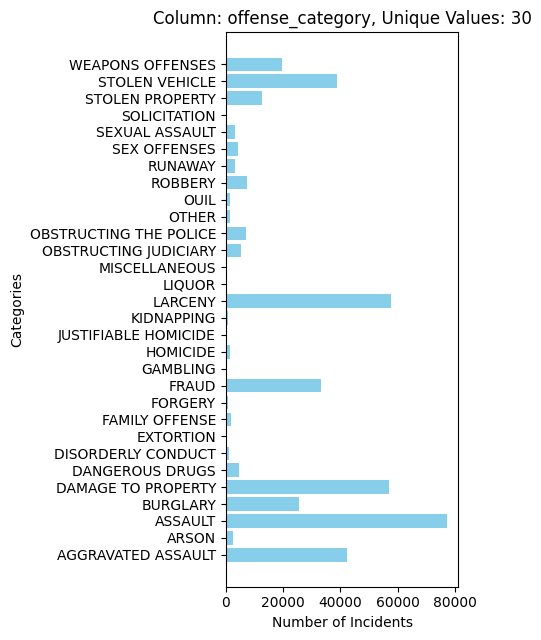

Column: offense_description, Unique Values: 103
[('ASSAULT AND BATTERY/SIMPLE ASSAULT', 82007), ('AGGRAVATED / FELONIOUS ASSAULT', 48128), ('DAMAGE TO PROPERTY', 41915), ('MOTOR VEHICLE THEFT', 37829), ('BURGLARY - FORCED ENTRY', 19476), ('LARCENY - PERSONAL PROPERTY FROM MOTOR VEHICLE', 18041), ('LARCENY - OTHER', 16362), ('WEAPONS OFFENSE - CONCEALED', 13030), ('LARCENY - THEFT FROM BUILDING', 12003), ('MOTOR VEHICLE AS STOLEN PROPERTY (RECOVERED ONLY)', 11406), ('LARCENY - THEFT OF MOTOR VEHICLE PARTS / ACCESSORIES', 10275), ('RETAIL FRAUD - THEFT', 9593), ('ROBBERY', 6912), ('FRAUD - FALSE PRETENSE / SWINDLE / CONFIDENCE GAME', 6685), ('INTIMIDATION / STALKING', 6208), ('FRAUD - CREDIT CARD/AUTOMATIC TELLER MACHINE', 5342), ('OBSTRUCTING POLICE', 5324), ('VIOLATION OF CONTROLED SUBSTANCE ACT - (VCSA)', 4972), ('OBSTRUCTING JUSTICE', 4447), ('FRAUD - IDENTITY THEFT', 4313), ('BURGLARY - ENTRY WITHOUT FORCE (INTENT TO COMMIT)', 3660), ('FRAUD - IMPERSONATION', 3414), ('RUNAWAY', 3057

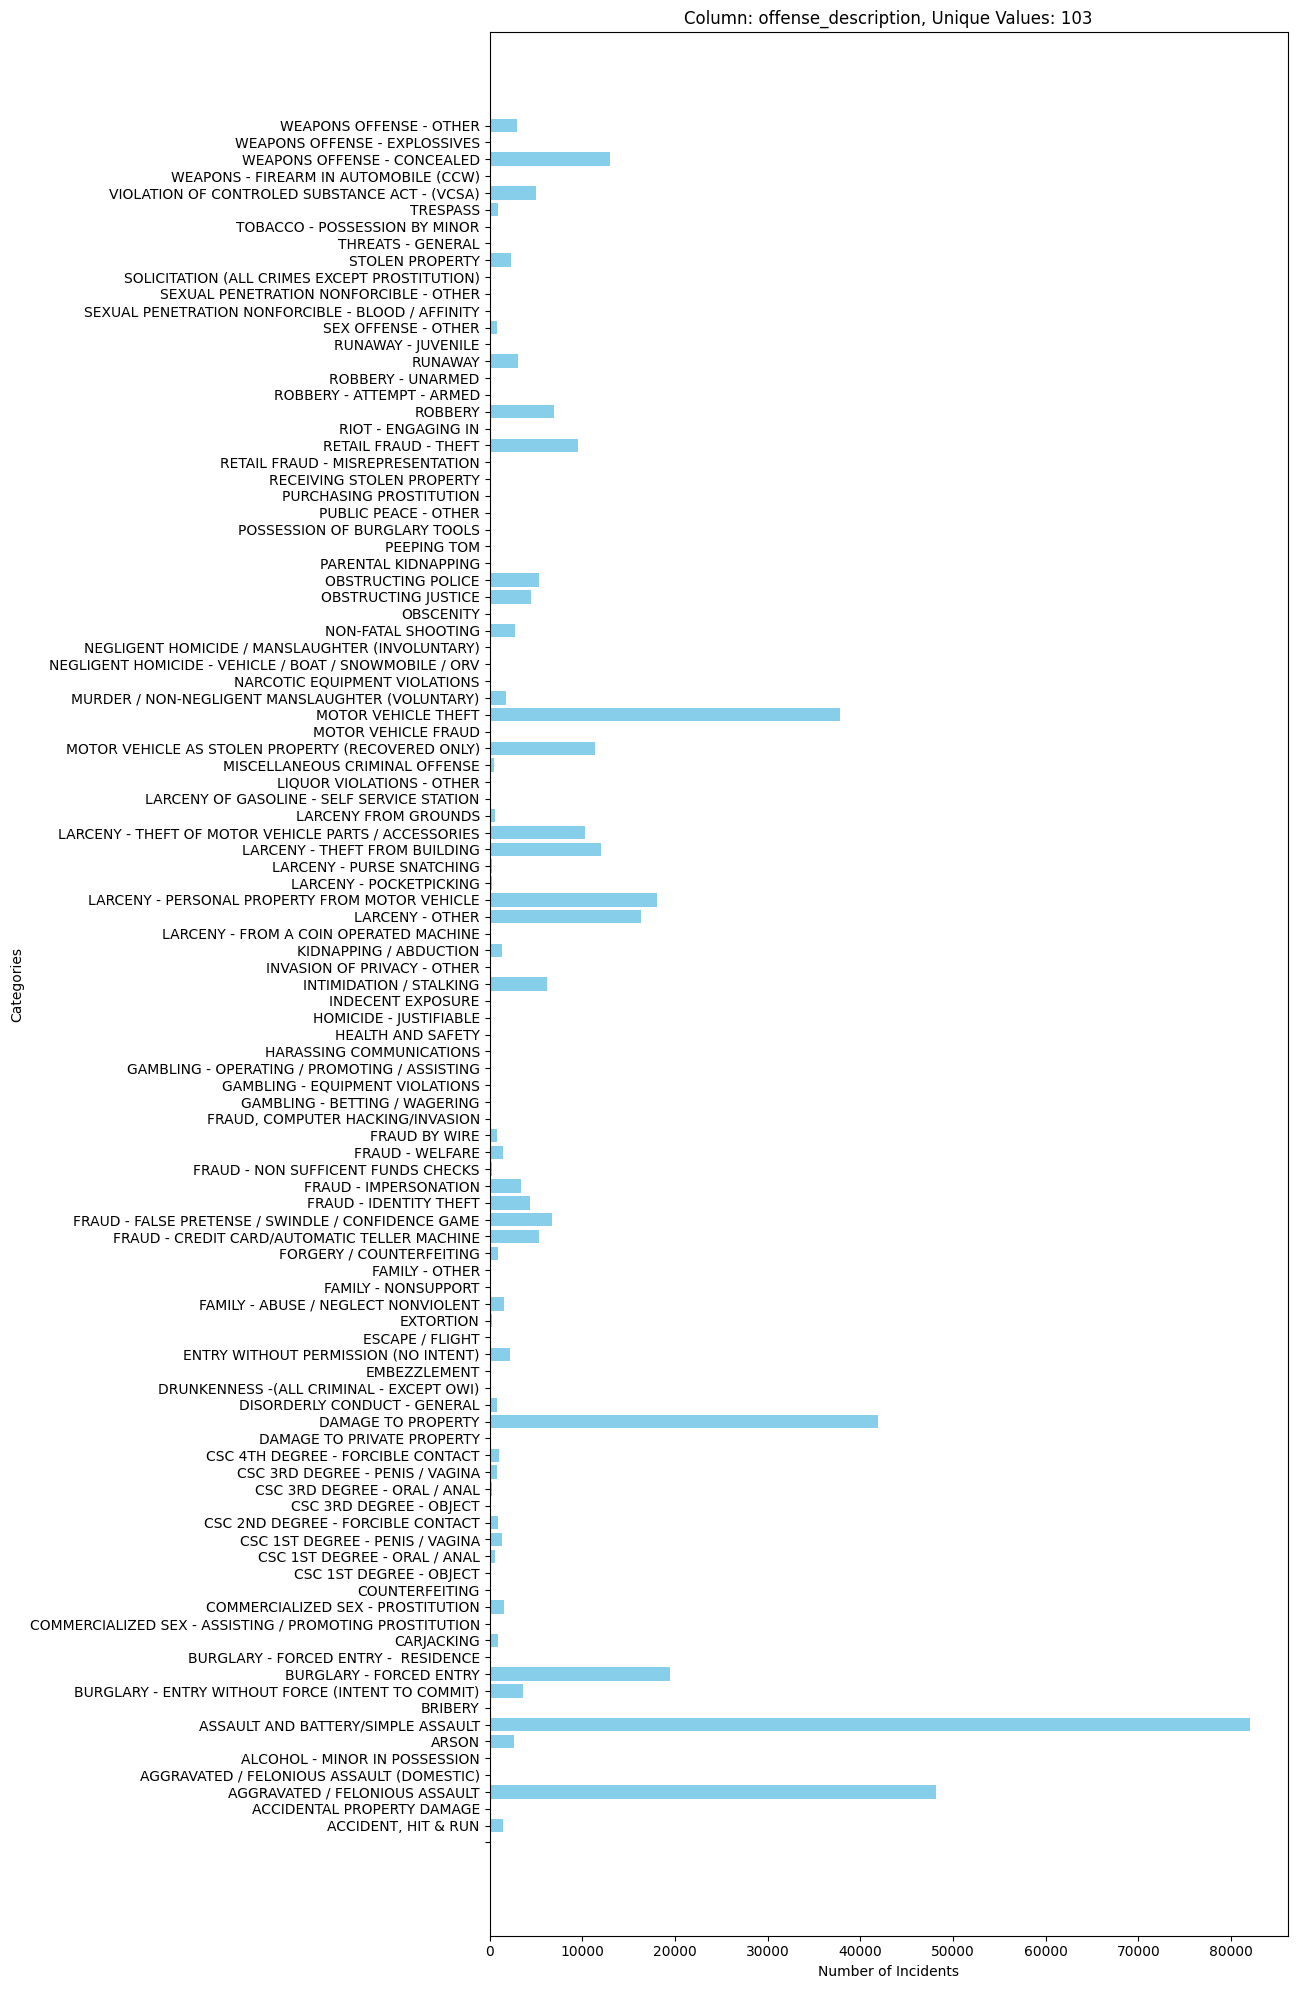

Column: state_offense_code, Unique Values: 77
[(1301, 71284), (2900, 56787), (1302, 39374), (2401, 38674), (2201, 19177), (2307, 18026), (2305, 16933), (5201, 15823), (2303, 11801), (2402, 10950), (2306, 10177), (3072, 9754), (1201, 7270), (4801, 6905), (2601, 6787), (1303, 5986), (2602, 5880), (5001, 5189), (3501, 4473), (2607, 4392), (2202, 3737), (5203, 3734), (2603, 3457), (7070, 3088), (1304, 2783), (2099, 2638), (2203, 2448), (3801, 1759), (2801, 1631), (4001, 1604), (2604, 1517), (901, 1303), (1171, 1263), (5701, 1248), (5301, 1058), (1178, 940), (2605, 902), (2501, 888), (1177, 855), (3692, 830), (1172, 793), (1001, 777), (5422, 745), (5421, 745), (1173, 635), (7399, 478), (2302, 305), (2301, 303), (1174, 280), (2101, 270), (3502, 254), (2606, 220), (4102, 206), (5501, 184), (3803, 164), (2608, 138), (904, 128), (1175, 117), (1002, 114), (2403, 111), (903, 86), (2204, 69), (1176, 60), (4003, 60), (2304, 54), (4002, 51), (5702, 32), (902, 25), (5302, 23), (3071, 21), (7571, 18),

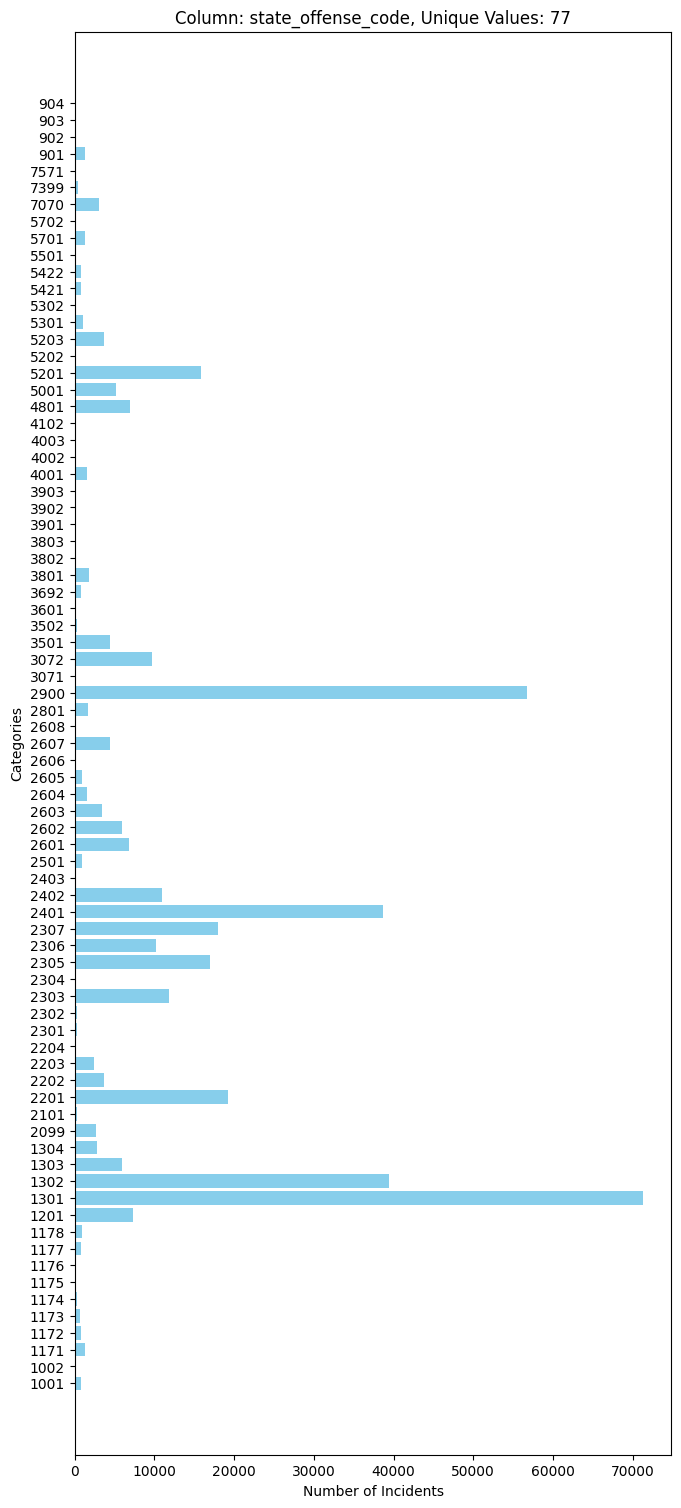

Column: latitude, Unique Values: 16990
Column: longitude, Unique Values: 16990
Column: nearest_intersection, Unique Values: 16213
Column: case_status, Unique Values: 9
[('INACTIVE', 268808), ('ACTIVE', 51558), ('CLEARED BY ARREST', 43564), ('EXCEPTIONALLY CLEARED', 36708), ('WARRANT OBTAINED', 8861), ('OTHER', 1222), ('UNFOUNDED', 83), ('WARRANT SUBMITTED', 2), ('PENDING', 1)]


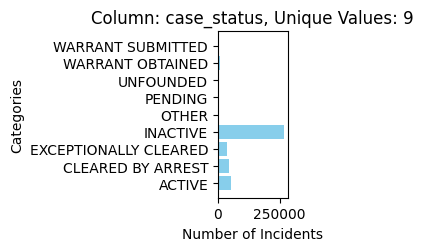

Column: police_precinct, Unique Values: 15
[('08', 51419), ('09', 50427), ('12', 43698), ('03', 42209), ('06', 41595), ('02', 37424), ('11', 32687), ('10', 32320), ('05', 28436), ('07', 26603), ('04', 23400), ('0', 533), ('HP', 41), ('00', 8), ('0W', 7)]


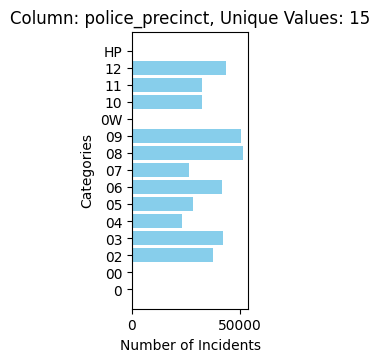

Column: council_district, Unique Values: 8
[(7, 63582), (2, 61225), (1, 58786), (5, 58611), (4, 56306), (3, 56189), (6, 52406), (None, 3702)]
hey


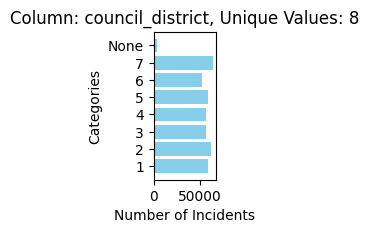

Column: neighborhood, Unique Values: 206
los_angeles_file
City los_angeles_file is show_distinct_values
Column: Date Rptd, Unique Values: 1790
Column: DATE OCC, Unique Values: 1790
Column: TIME OCC, Unique Values: 1439
Column: Crm Cd, Unique Values: 140
[(510, 111867), (624, 74244), (330, 62010), (354, 61141), (740, 60075), (310, 57461), (230, 52827), (440, 52327), (626, 46310), (420, 40804), (331, 35315), (341, 33947), (210, 32106), (442, 30144), (745, 25151), (930, 19097), (888, 18330), (761, 14357), (236, 12555), (901, 11663), (956, 8368), (480, 8047), (946, 6870), (900, 6188), (662, 6040), (343, 5568), (220, 4820), (625, 4213), (350, 4175), (668, 4167), (860, 4092), (320, 3949), (520, 3786), (121, 3729), (352, 3607), (627, 3574), (649, 3343), (522, 2845), (753, 2651), (903, 2542), (623, 2533), (648, 2531), (664, 2040), (940, 1987), (812, 1796), (890, 1677), (251, 1635), (110, 1553), (886, 1497), (815, 1326), (850, 1199), (237, 1178), (810, 1082), (231, 1066), (813, 1037), (437, 103

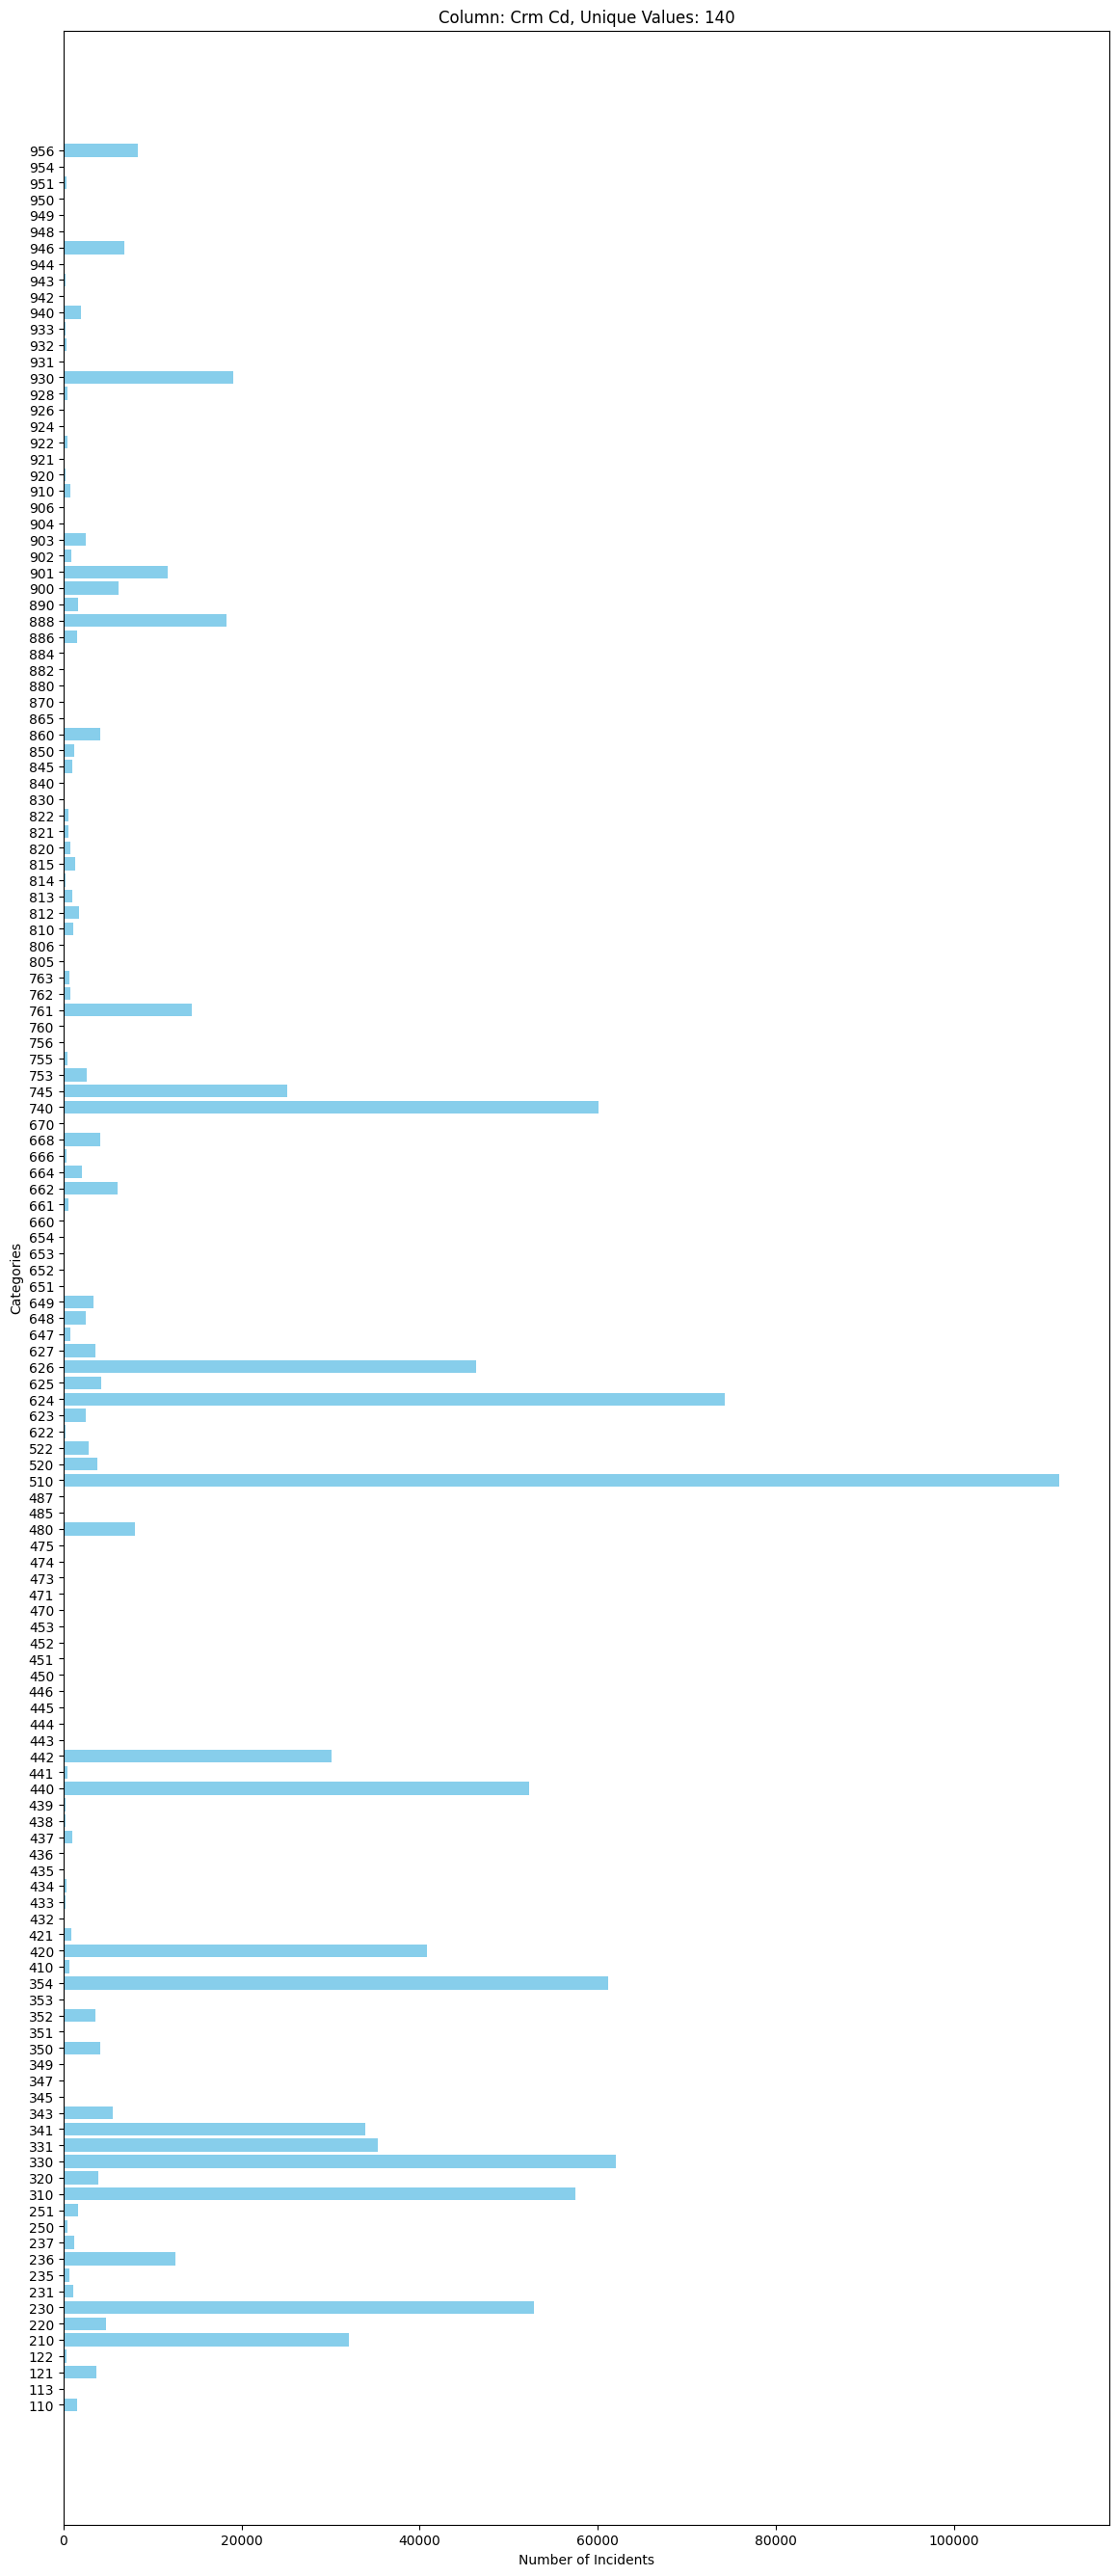

Column: Crm Cd Desc, Unique Values: 140
[('VEHICLE - STOLEN', 111867), ('BATTERY - SIMPLE ASSAULT', 74244), ('BURGLARY FROM VEHICLE', 62010), ('THEFT OF IDENTITY', 61141), ('VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 60075), ('BURGLARY', 57461), ('ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 52827), ('THEFT PLAIN - PETTY ($950 & UNDER)', 52327), ('INTIMATE PARTNER - SIMPLE ASSAULT', 46310), ('THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)', 40804), ('THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 35315), ('THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD', 33947), ('ROBBERY', 32106), ('SHOPLIFTING - PETTY THEFT ($950 & UNDER)', 30144), ('VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 25151), ('CRIMINAL THREATS - NO WEAPON DISPLAYED', 19097), ('TRESPASSING', 18330), ('BRANDISH WEAPON', 14357), ('INTIMATE PARTNER - AGGRAVATED ASSAULT', 12555), ('VIOLATION OF RESTRAINING ORDER', 11663), ('LETTERS, LEWD  -  TELEPHONE CALLS, LEWD', 8368), ('BIKE - STOLEN', 804

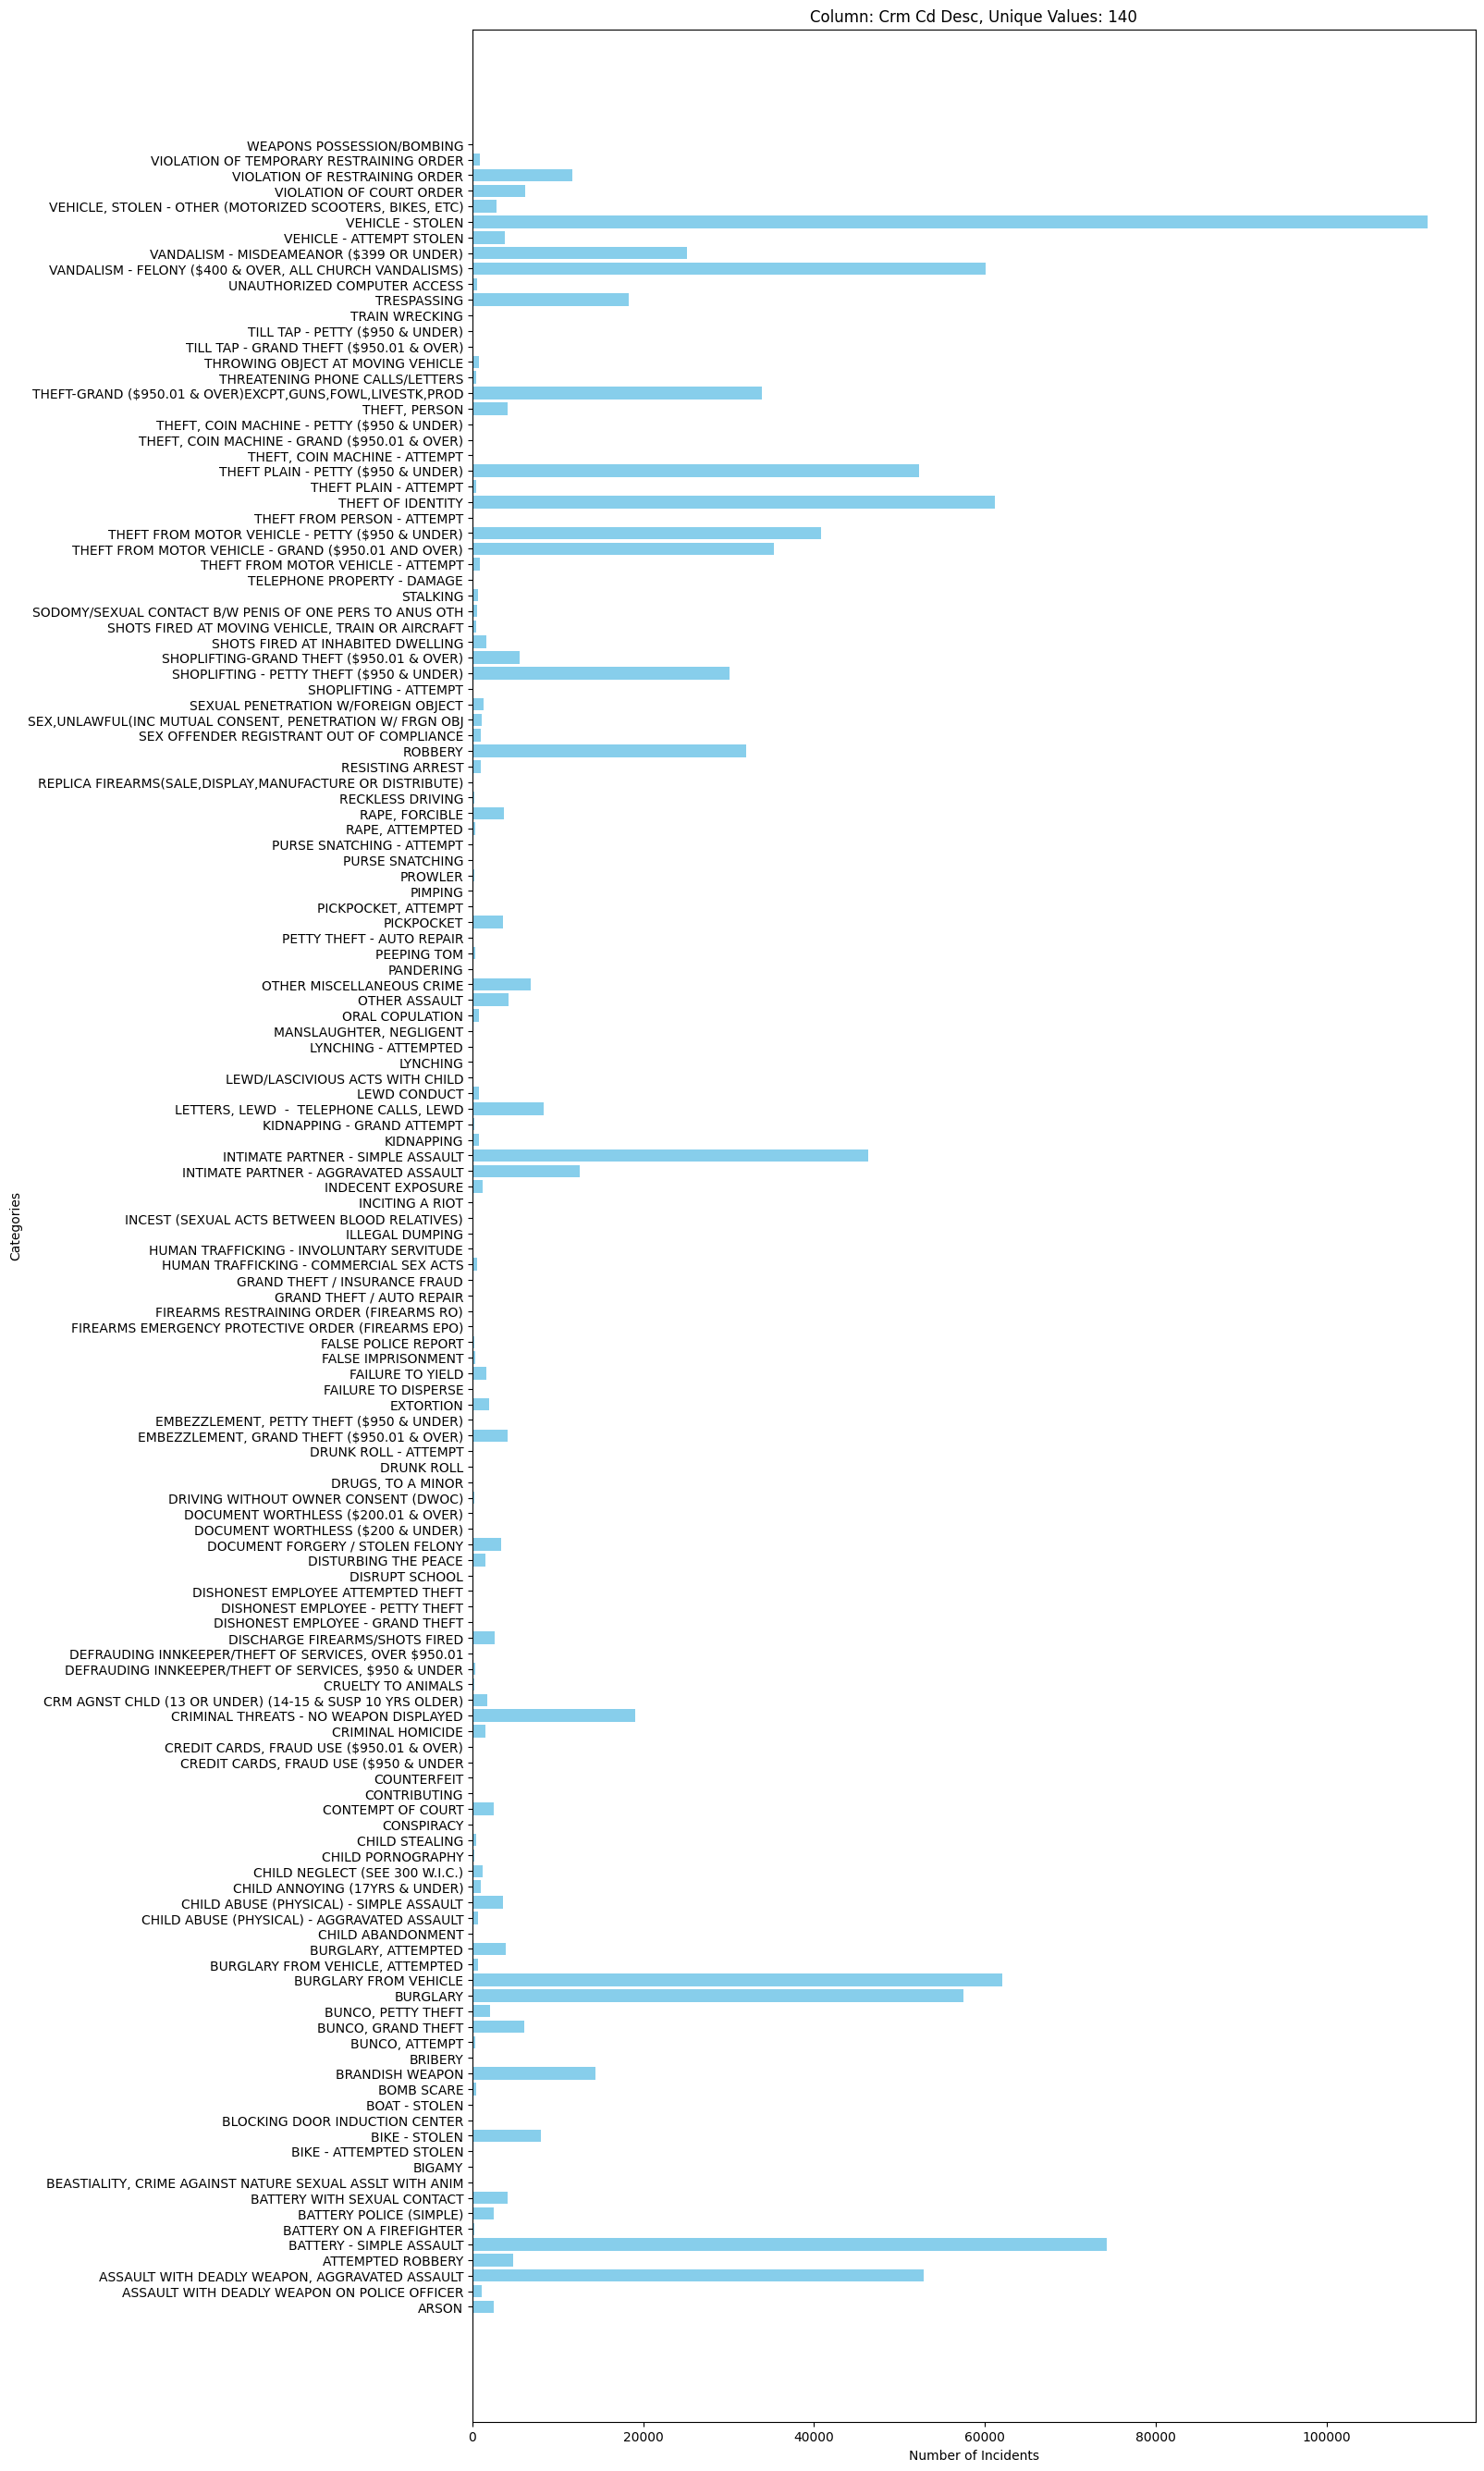

Column: AREA, Unique Values: 21
[(1, 68966), (12, 61646), (14, 58881), (3, 56972), (6, 52107), (18, 50101), (13, 48917), (20, 48519), (7, 47942), (2, 46520), (15, 46174), (8, 45273), (9, 42642), (11, 42576), (10, 41879), (5, 41071), (17, 40875), (21, 40546), (19, 40317), (4, 36755), (16, 28194)]


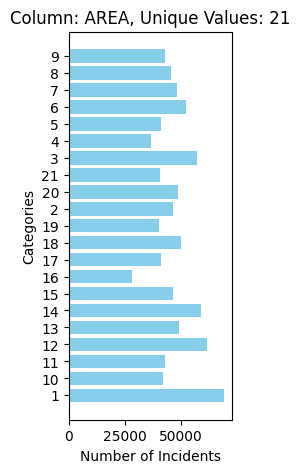

Column: AREA NAME, Unique Values: 21
[('Central', 68966), ('77th Street', 61646), ('Pacific', 58881), ('Southwest', 56972), ('Hollywood', 52107), ('Southeast', 50101), ('Newton', 48917), ('Olympic', 48519), ('Wilshire', 47942), ('Rampart', 46520), ('N Hollywood', 46174), ('West LA', 45273), ('Van Nuys', 42642), ('Northeast', 42576), ('West Valley', 41879), ('Harbor', 41071), ('Devonshire', 40875), ('Topanga', 40546), ('Mission', 40317), ('Hollenbeck', 36755), ('Foothill', 28194)]


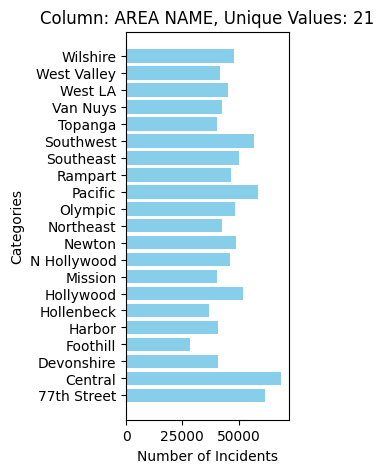

Column: LAT, Unique Values: 5391
Column: LON, Unique Values: 4968
Column: LOCATION, Unique Values: 65273
Column: Premis Cd, Unique Values: 314
Column: Premis Desc, Unique Values: 306
Column: Status Desc, Unique Values: 6
[('Invest Cont', 789360), ('Adult Other', 107087), ('Adult Arrest', 85346), ('Juv Arrest', 3252), ('Juv Other', 1821), ('UNK', 7)]


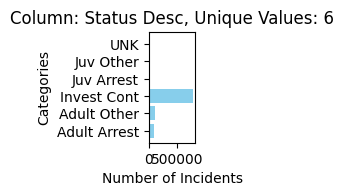

Column: Vict Age, Unique Values: 104
[(0, 263670), (30, 21935), (35, 21195), (31, 21080), (29, 21074), (28, 20591), (32, 20378), (33, 19957), (27, 19779), (34, 19076), (26, 19007), (25, 18845), (36, 17822), (24, 17640), (23, 17496), (37, 17149), (38, 16625), (22, 16452), (39, 15851), (40, 15589), (41, 14665), (21, 14170), (42, 13806), (43, 13527), (44, 12782), (50, 12461), (45, 12255), (20, 11796), (47, 11669), (46, 11610), (48, 11041), (49, 10811), (51, 10670), (52, 10265), (53, 10111), (19, 9910), (54, 9715), (55, 9487), (56, 8797), (57, 8754), (58, 8402), (59, 8103), (60, 7958), (61, 7241), (62, 6909), (63, 6508), (64, 6142), (18, 6044), (65, 5689), (66, 5164), (67, 4666), (17, 4240), (68, 4207), (16, 3906), (69, 3719), (15, 3525), (70, 3444), (71, 3142), (14, 2994), (72, 2933), (73, 2730), (13, 2489), (74, 2366), (75, 2024), (76, 1833), (12, 1773), (77, 1654), (78, 1487), (79, 1244), (11, 1215), (80, 1195), (81, 916), (82, 899), (83, 822), (10, 801), (9, 711), (8, 637), (84, 617), 

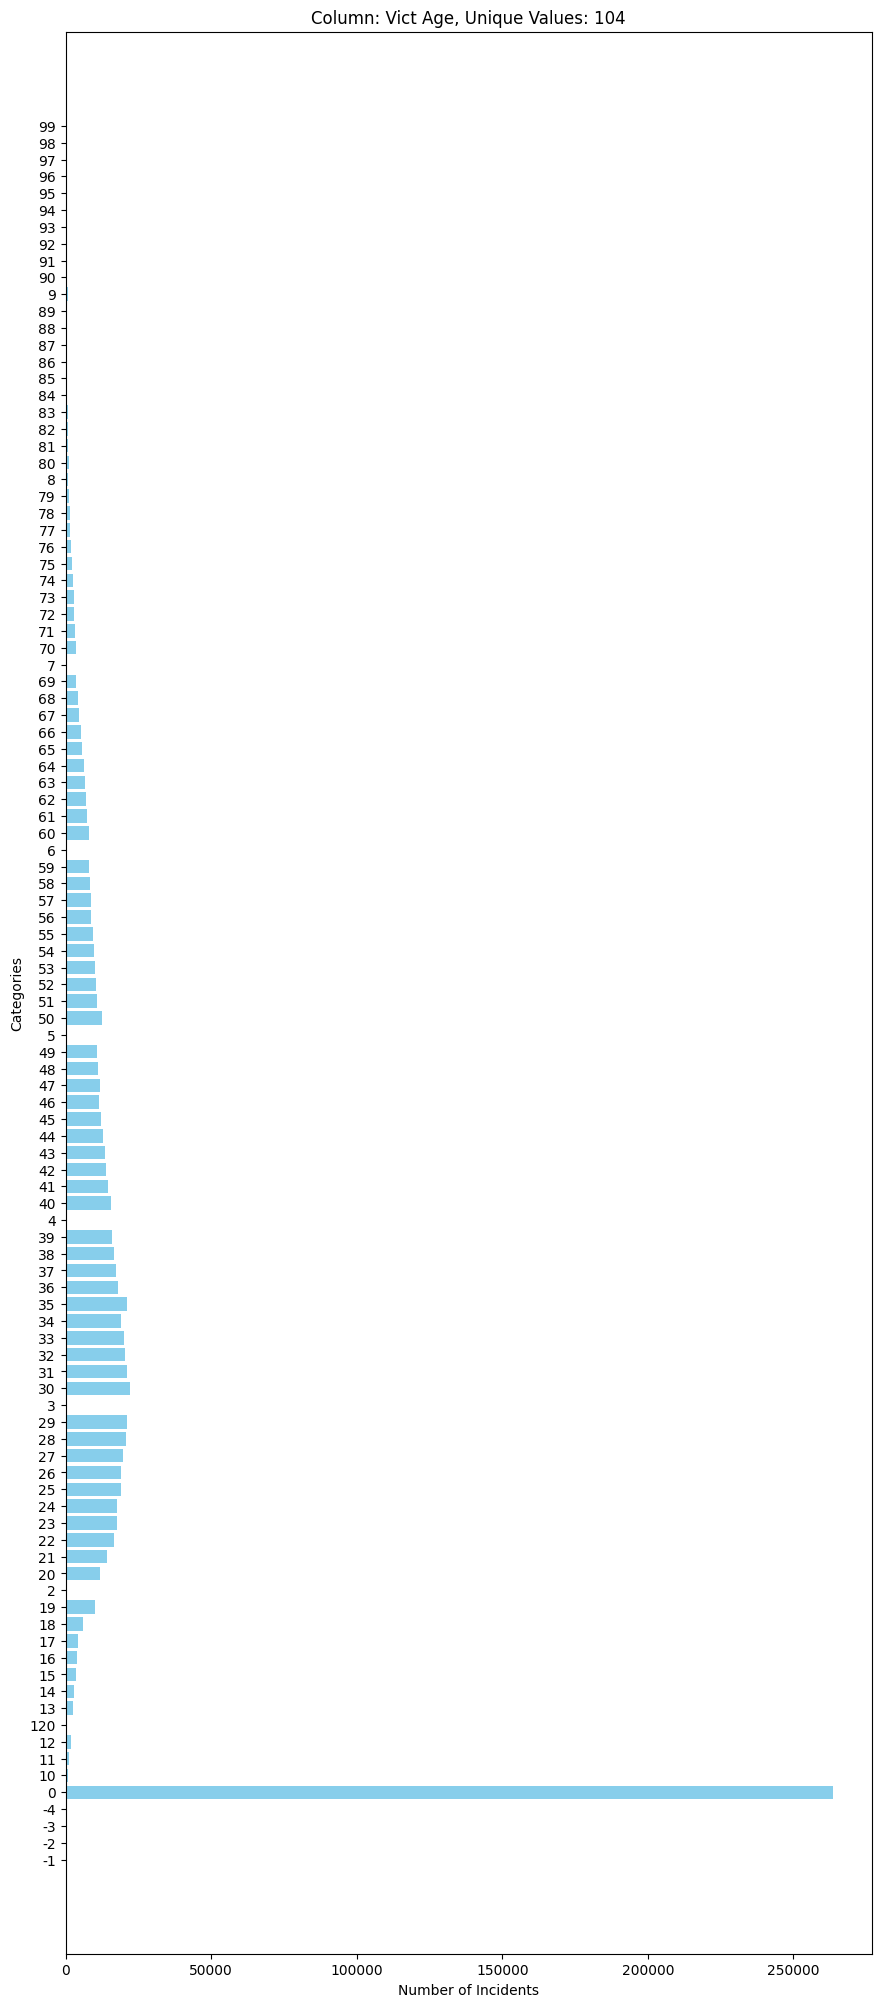

Column: Vict Sex, Unique Values: 6
[('M', 396543), ('F', 352487), (None, 140607), ('X', 97125), ('H', 110), ('-', 1)]
hey


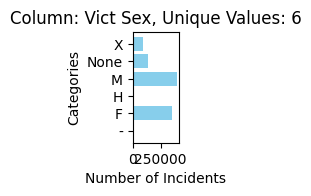

Column: Vict Descent, Unique Values: 21
[('H', 291470), ('W', 197170), (None, 140619), ('B', 134735), ('X', 105839), ('O', 76337), ('A', 21174), ('K', 5683), ('F', 4502), ('C', 4429), ('J', 1512), ('V', 1146), ('I', 961), ('Z', 527), ('P', 280), ('U', 206), ('D', 86), ('L', 73), ('G', 68), ('S', 54), ('-', 2)]
hey


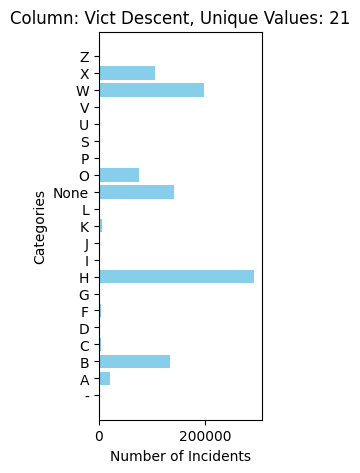

new_york_file
City new_york_file is show_distinct_values
Column: CMPLNT_FR_DT, Unique Values: 1735
Column: CMPLNT_FR_TM, Unique Values: 1440
Column: RPT_DT, Unique Values: 1735
Column: KY_CD, Unique Values: 70
[(341, 474695), (578, 371578), (344, 252241), (109, 213251), (351, 143573), (106, 120056), (361, 82511), (105, 73912), (126, 72228), (348, 69086), (107, 67590), (121, 64946), (110, 59750), (359, 31450), (233, 28798), (117, 25499), (235, 23277), (113, 23202), (118, 22285), (112, 14997), (343, 14191), (347, 13658), (358, 12295), (352, 11407), (340, 10276), (236, 10052), (353, 7032), (104, 6167), (355, 5983), (111, 5092), (116, 4724), (125, 4485), (365, 3436), (232, 3342), (114, 3214), (675, 2908), (364, 2658), (678, 2392), (101, 1988), (231, 1611), (342, 1329), (350, 732), (250, 713), (124, 619), (363, 583), (677, 488), (356, 477), (572, 431), (346, 326), (120, 269), (238, 247), (230, 191), (345, 161), (115, 137), (237, 94), (103, 87), (354, 44), (122, 43), (455, 41), (119, 25), (5

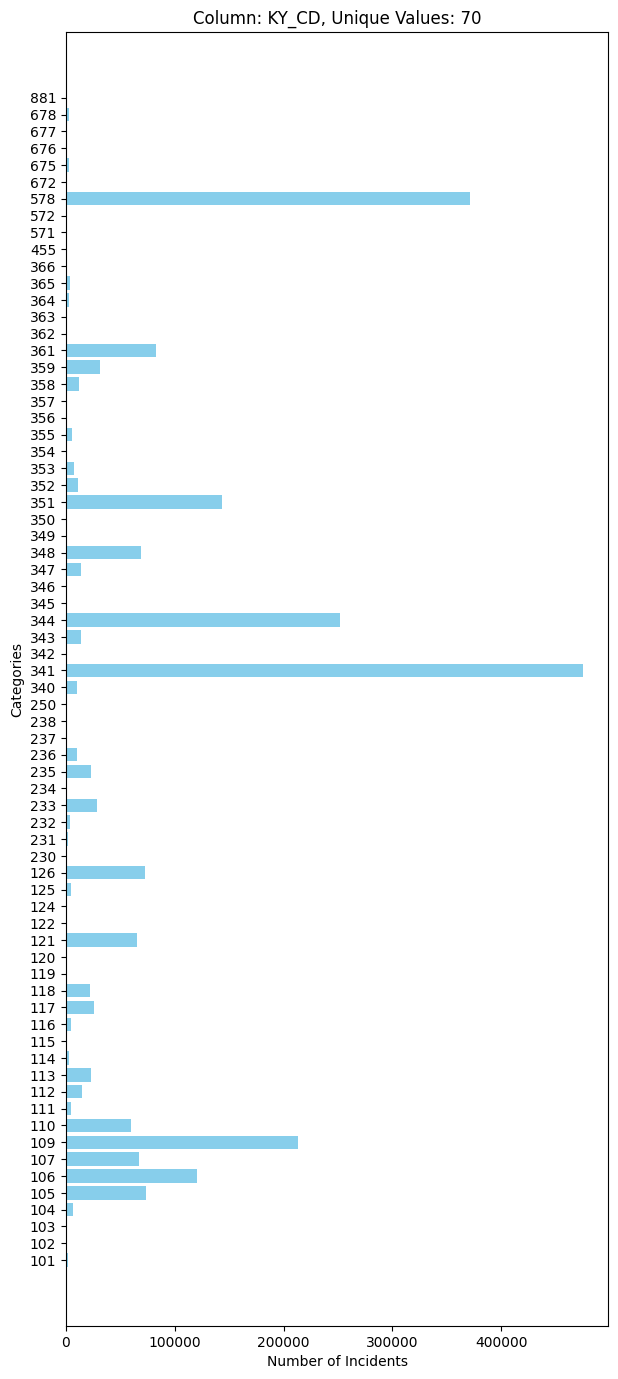

Column: OFNS_DESC, Unique Values: 69
[('PETIT LARCENY', 474695), ('HARRASSMENT 2', 371578), ('ASSAULT 3 & RELATED OFFENSES', 252241), ('GRAND LARCENY', 213251), ('CRIMINAL MISCHIEF & RELATED OF', 208519), ('FELONY ASSAULT', 120056), ('OFF. AGNST PUB ORD SENSBLTY &', 82508), ('MISCELLANEOUS PENAL LAW', 74588), ('ROBBERY', 73912), ('VEHICLE AND TRAFFIC LAWS', 69120), ('BURGLARY', 67590), ('GRAND LARCENY OF MOTOR VEHICLE', 59750), ('DANGEROUS DRUGS', 48776), ('SEX CRIMES', 33485), ('DANGEROUS WEAPONS', 32337), ('OFFENSES AGAINST PUBLIC ADMINI', 31450), ('FORGERY', 23202), ('THEFT-FRAUD', 14997), ('INTOXICATED & IMPAIRED DRIVING', 13658), ('OFFENSES INVOLVING FRAUD', 12295), ('CRIMINAL TRESPASS', 11407), ('FRAUDS', 10276), ('OTHER OFFENSES RELATED TO THEFT', 9069), ('POSSESSION OF STOLEN PROPERTY', 8434), ('UNAUTHORIZED USE OF A VEHICLE', 7032), ('ADMINISTRATIVE CODE', 6340), ('RAPE', 6167), ('OFFENSES AGAINST THE PERSON', 5983), ('OTHER OFFENSES RELATED TO THEF', 4480), ('ARSON', 3214), (

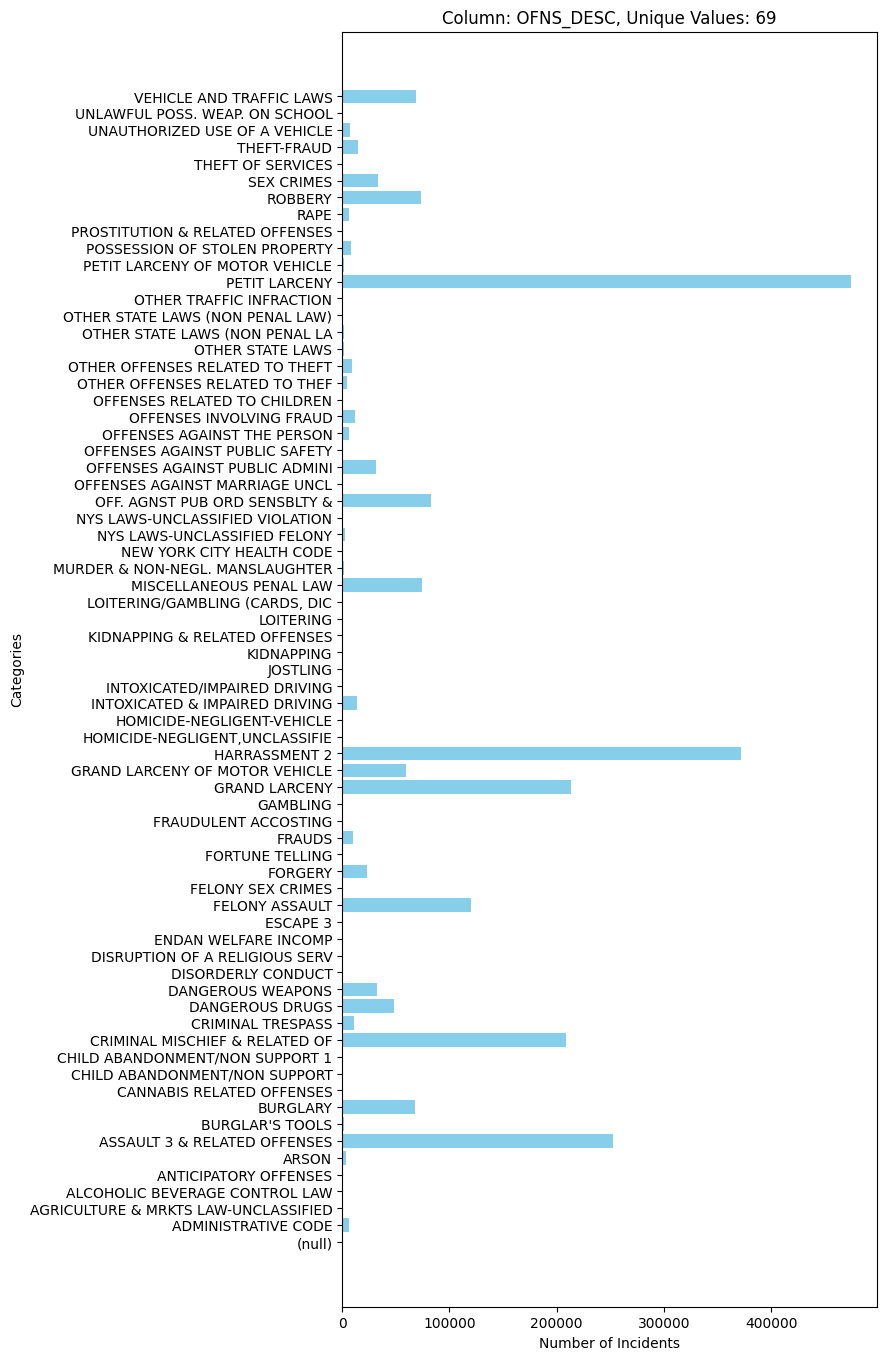

Column: ADDR_PCT_CD, Unique Values: 78
[(75, 73904), (40, 57191), (44, 56493), (14, 55605), (43, 54552), (47, 50432), (114, 50143), (46, 46657), (109, 46538), (52, 45156), (73, 44340), (103, 43839), (67, 43558), (42, 43239), (110, 42836), (115, 41883), (48, 39515), (105, 38927), (19, 38130), (18, 37883), (120, 36985), (113, 36330), (79, 35899), (1, 35204), (25, 33641), (70, 32800), (83, 32565), (13, 32508), (49, 32140), (104, 31291), (106, 30354), (108, 29711), (62, 29612), (32, 29564), (41, 29315), (45, 29252), (102, 29214), (34, 29105), (60, 29074), (23, 29048), (121, 28893), (90, 28794), (107, 28461), (71, 28227), (77, 27127), (6, 26859), (72, 26305), (61, 26202), (9, 26163), (84, 25953), (7, 24445), (50, 24277), (28, 23752), (81, 23469), (122, 23411), (68, 22810), (63, 22732), (33, 22174), (24, 21849), (66, 21296), (101, 21129), (5, 20221), (30, 20150), (69, 20126), (112, 19617), (78, 19513), (94, 19401), (10, 19116), (20, 18638), (88, 18603), (17, 17176), (111, 15882), (26, 14196)

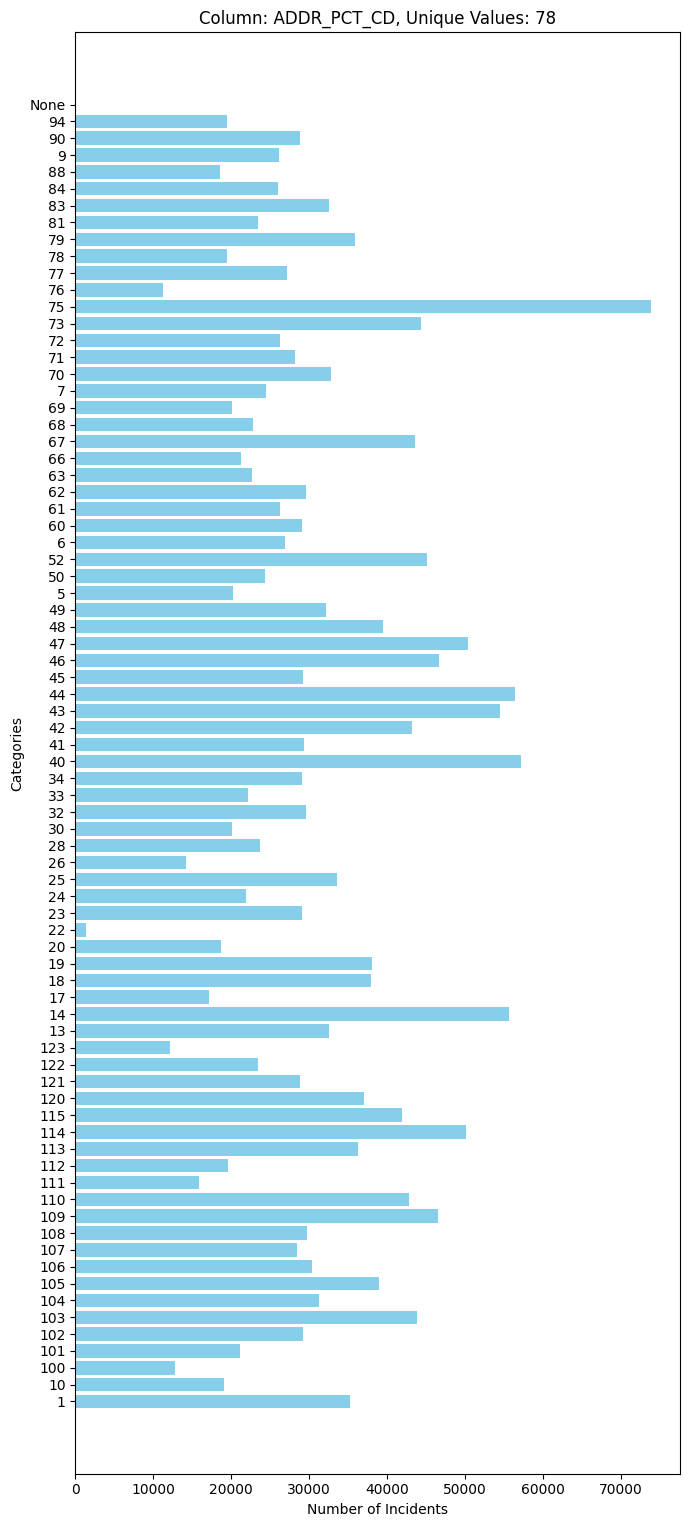

Column: BORO_NM, Unique Values: 6
[('BROOKLYN', 663549), ('MANHATTAN', 574080), ('QUEENS', 518328), ('BRONX', 508262), ('STATEN ISLAND', 101421), ('(null)', 3330)]


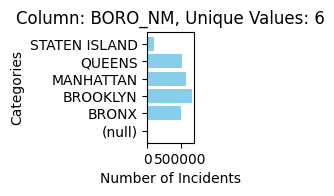

Column: PATROL_BORO, Unique Values: 9
[('PATROL BORO BRONX', 508240), ('PATROL BORO BKLYN SOUTH', 333509), ('PATROL BORO BKLYN NORTH', 330065), ('PATROL BORO MAN SOUTH', 295191), ('PATROL BORO MAN NORTH', 281575), ('PATROL BORO QUEENS NORTH', 277903), ('PATROL BORO QUEENS SOUTH', 241044), ('PATROL BORO STATEN ISLAND', 101419), ('(null)', 24)]


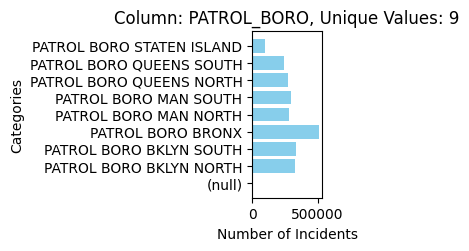

Column: PREM_TYP_DESC, Unique Values: 88
[('STREET', 692470), ('RESIDENCE - APT. HOUSE', 524134), ('RESIDENCE-HOUSE', 223329), ('RESIDENCE - PUBLIC HOUSING', 157837), ('CHAIN STORE', 115665), ('TRANSIT - NYC SUBWAY', 59349), ('DEPARTMENT STORE', 57587), ('COMMERCIAL BUILDING', 51605), ('DRUG STORE', 50920), ('OTHER', 46548), ('(null)', 36478), ('GROCERY/BODEGA', 36159), ('HOMELESS SHELTER', 25068), ('RESTAURANT/DINER', 24366), ('CLOTHING/BOUTIQUE', 20722), ('PARK/PLAYGROUND', 20084), ('BAR/NIGHT CLUB', 15385), ('HOTEL/MOTEL', 13306), ('PUBLIC SCHOOL', 12346), ('FAST FOOD', 12223), ('PARKING LOT/GARAGE (PUBLIC)', 10460), ('HOSPITAL', 10018), ('FOOD SUPERMARKET', 9925), ('PARKING LOT/GARAGE (PRIVATE)', 8560), ('HIGHWAY/PARKWAY', 8387), ('BANK', 7914), ('PUBLIC BUILDING', 7251), ('SMALL MERCHANT', 6667), ('GAS STATION', 6588), ('STORE UNCLASSIFIED', 6199), ('BEAUTY & NAIL SALON', 5897), ('BUS (NYC TRANSIT)', 5450), ('GYM/FITNESS FACILITY', 4918), ('CONSTRUCTION SITE', 4862), ('DOCTOR/DENT

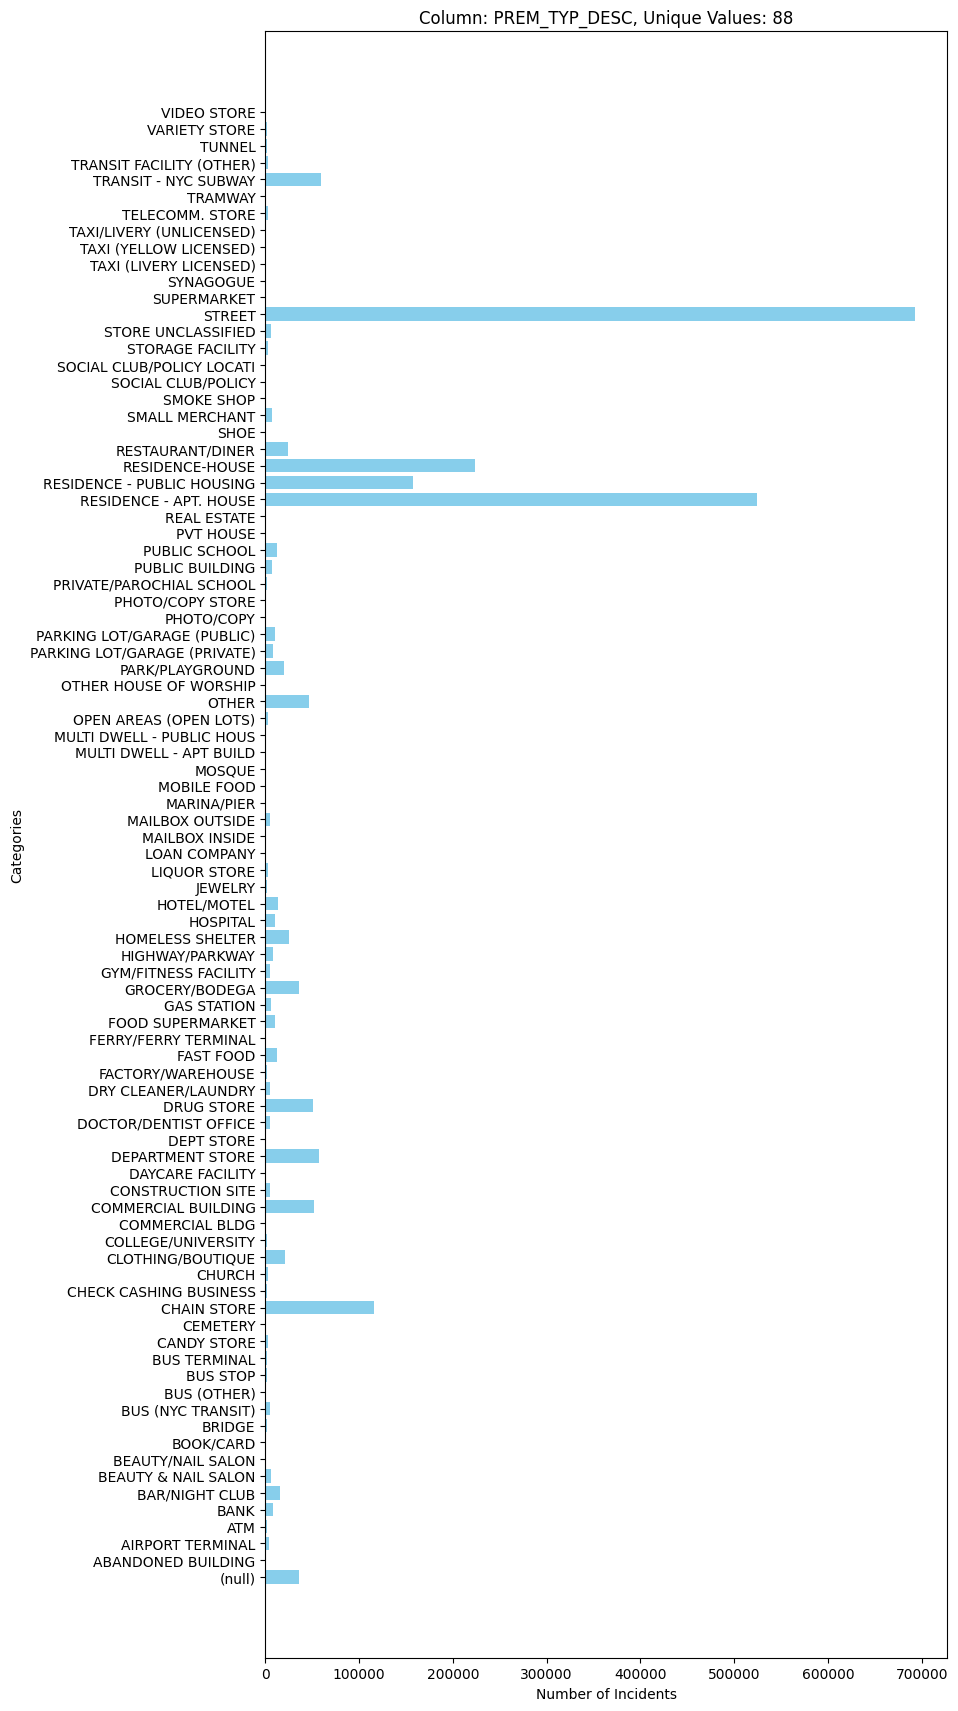

Column: CRM_ATPT_CPTD_CD, Unique Values: 3
[('COMPLETED', 2334120), ('ATTEMPTED', 34689), ('(null)', 161)]


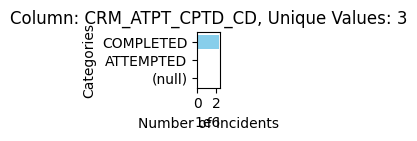

Column: Latitude, Unique Values: 113653
Column: Longitude, Unique Values: 114779
Column: VIC_AGE_GROUP, Unique Values: 89
[('25-44', 854877), ('UNKNOWN', 666335), ('45-64', 450556), ('18-24', 200325), ('65+', 115743), ('<18', 81007), ('1023', 6), ('-1', 4), ('-2', 4), ('-30', 3), ('-961', 3), ('-3', 3), ('-964', 3), ('-4', 2), ('-6', 2), ('-960', 2), ('-965', 2), ('953', 2), ('1022', 2), ('-61', 2), ('-971', 2), ('-973', 2), ('-951', 2), ('-65', 2), ('-60', 2), ('963', 2), ('1018', 2), ('949', 2), ('950', 2), ('-968', 2), ('-948', 2), ('-963', 2), ('-970', 2), ('934', 2), ('-975', 2), ('-5', 2), ('-958', 2), ('-48', 2), ('940', 1), ('-953', 1), ('-959', 1), ('938', 1), ('970', 1), ('-929', 1), ('966', 1), ('-921', 1), ('1013', 1), ('-46', 1), ('-938', 1), ('-924', 1), ('1016', 1), ('-967', 1), ('-944', 1), ('(null)', 1), ('943', 1), ('932', 1), ('-972', 1), ('962', 1), ('936', 1), ('957', 1), ('-943', 1), ('1020', 1), ('-955', 1), ('-934', 1), ('-962', 1), ('944', 1), ('-62', 1), ('-93

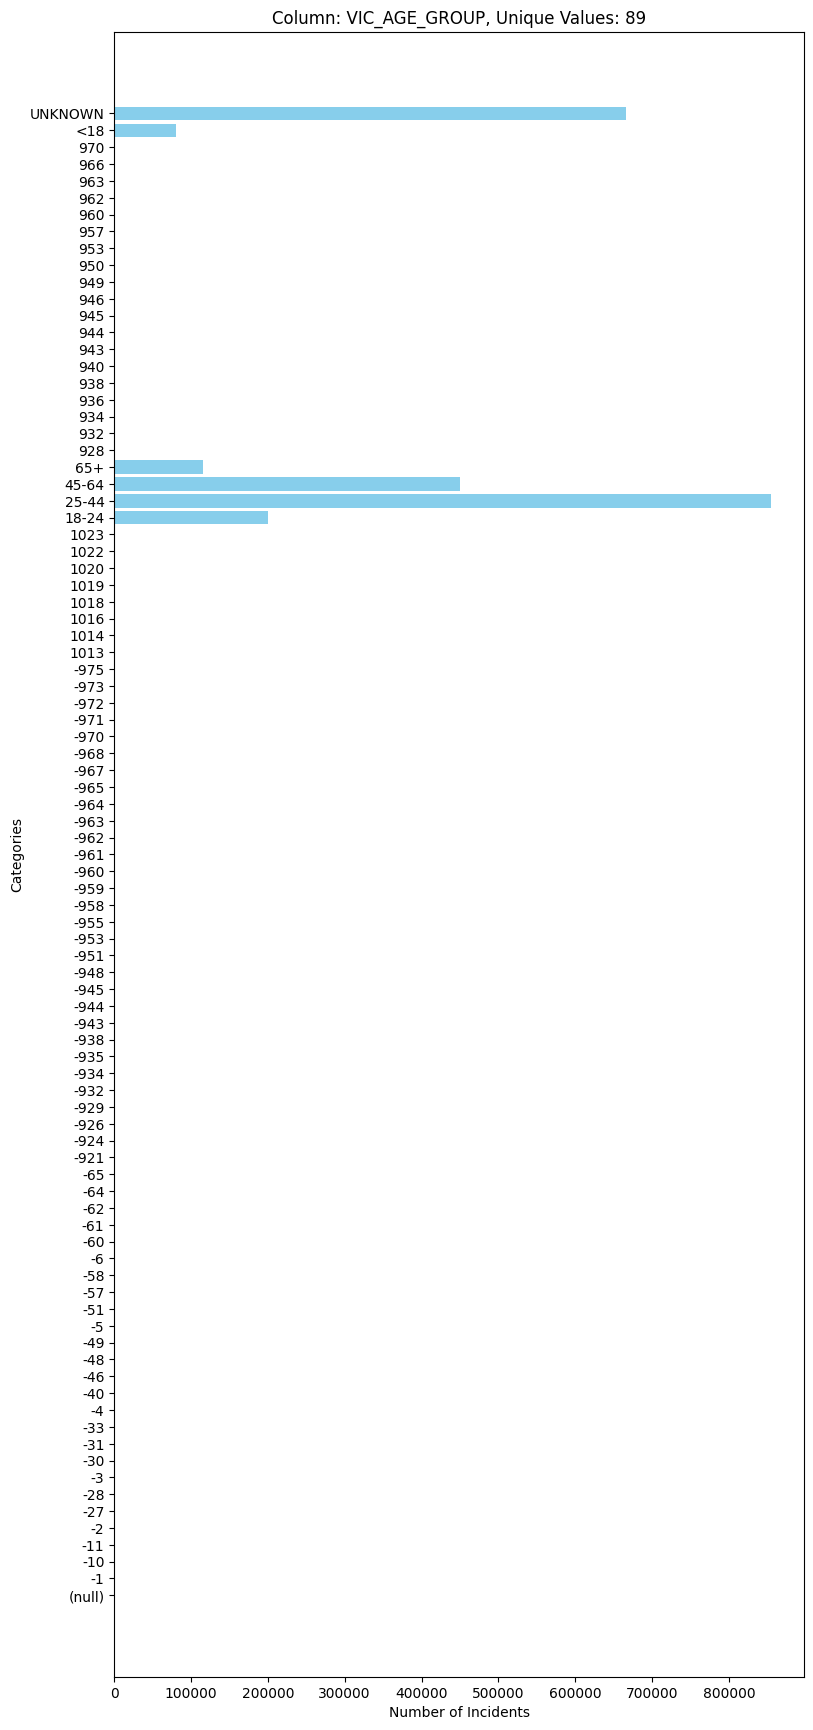

Column: VIC_RACE, Unique Values: 8
[('UNKNOWN', 716409), ('BLACK', 587667), ('WHITE HISPANIC', 422612), ('WHITE', 342399), ('ASIAN / PACIFIC ISLANDER', 188033), ('BLACK HISPANIC', 102179), ('AMERICAN INDIAN/ALASKAN NATIVE', 9253), ('(null)', 418)]


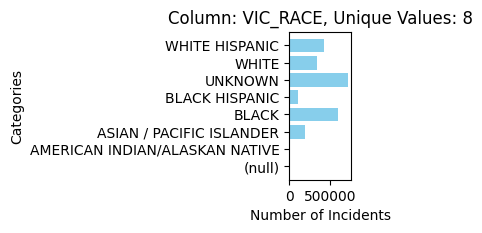

Column: VIC_SEX, Unique Values: 6
[('F', 907536), ('M', 825950), ('D', 389394), ('E', 236818), ('L', 9271), ('(null)', 1)]


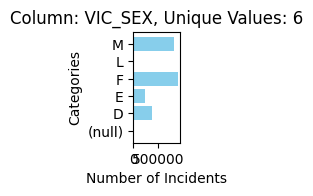

Column: SUSP_AGE_GROUP, Unique Values: 83
[('UNKNOWN', 887986), ('25-44', 633108), ('(null)', 396641), ('45-64', 216267), ('18-24', 167797), ('<18', 43583), ('65+', 23385), ('1022', 25), ('1023', 20), ('2021', 19), ('2022', 17), ('2023', 13), ('2020', 10), ('2024', 7), ('-1', 3), ('-6', 3), ('-969', 3), ('-973', 3), ('-951', 3), ('942', 3), ('953', 3), ('2019', 2), ('-941', 2), ('-946', 2), ('-47', 2), ('-3', 2), ('938', 2), ('-971', 2), ('-956', 2), ('1024', 2), ('-30', 1), ('-71', 1), ('-959', 1), ('-62', 1), ('-55', 1), ('1032', 1), ('924', 1), ('-965', 1), ('-74', 1), ('933', 1), ('964', 1), ('-966', 1), ('-924', 1), ('-66', 1), ('1017', 1), ('-961', 1), ('967', 1), ('-972', 1), ('-69', 1), ('-60', 1), ('929', 1), ('958', 1), ('-947', 1), ('-963', 1), ('955', 1), ('-33', 1), ('-5962', 1), ('934', 1), ('-976', 1), ('-76', 1), ('-955', 1), ('-975', 1), ('-2', 1), ('-5', 1), ('925', 1), ('956', 1), ('-942', 1), ('940', 1), ('-953', 1), ('1056', 1), ('951', 1), ('1822', 1), ('-10', 1),

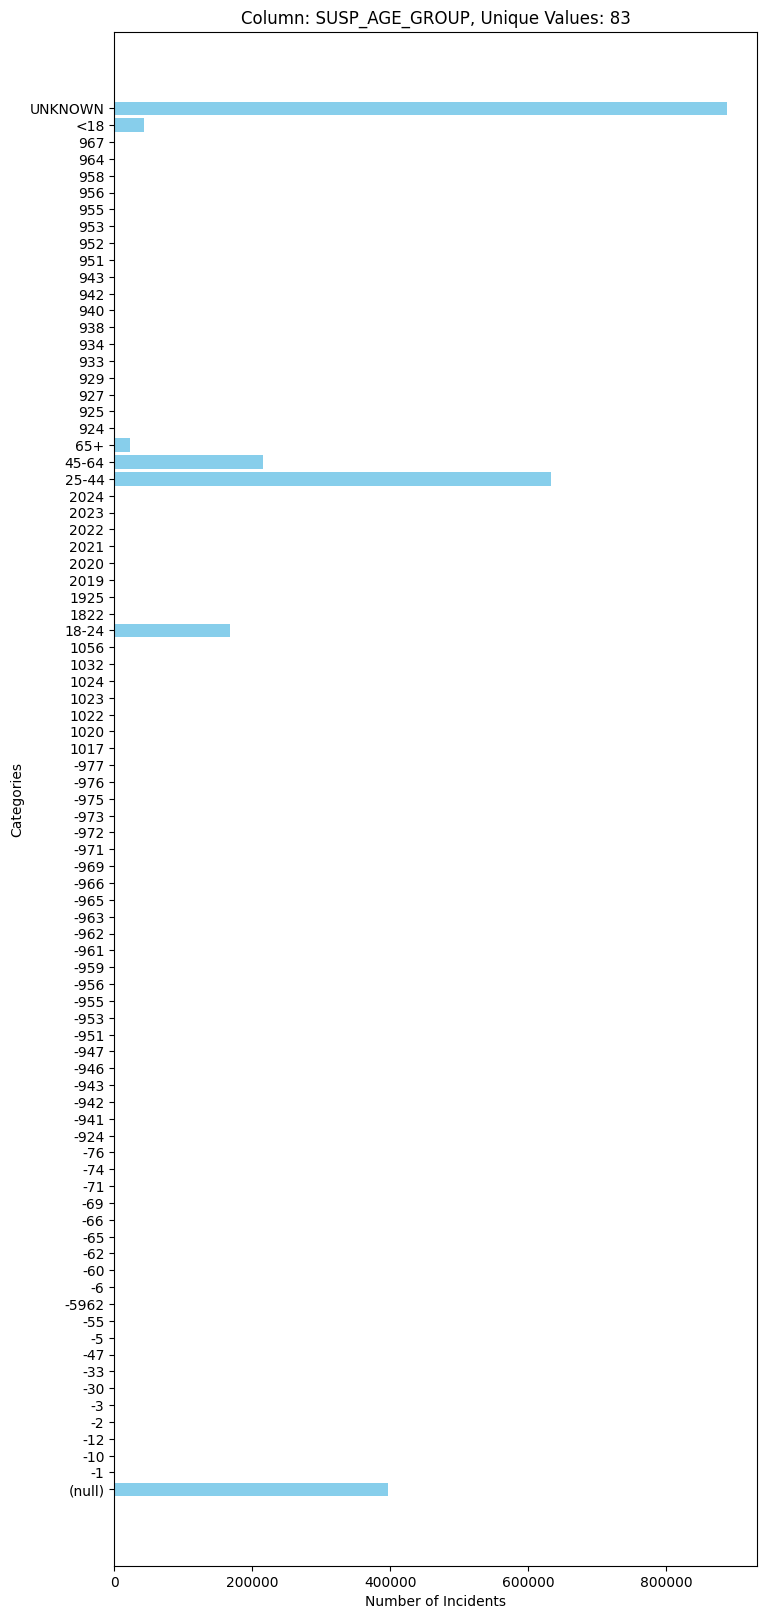

Column: SUSP_RACE, Unique Values: 8
[('BLACK', 700655), ('UNKNOWN', 594146), ('(null)', 396641), ('WHITE HISPANIC', 323661), ('WHITE', 172000), ('BLACK HISPANIC', 106055), ('ASIAN / PACIFIC ISLANDER', 71387), ('AMERICAN INDIAN/ALASKAN NATIVE', 4425)]


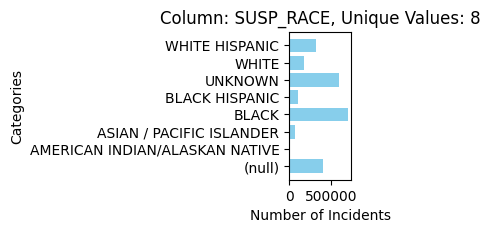

Column: SUSP_SEX, Unique Values: 4
[('M', 1159903), ('U', 497356), ('(null)', 396641), ('F', 315070)]


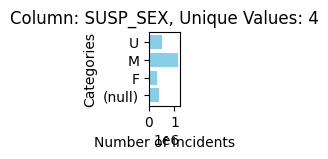

san_francisco_file
City san_francisco_file is show_distinct_values
Column: Incident Datetime, Unique Values: 298050
Column: Report Datetime, Unique Values: 438473
Column: Incident Code, Unique Values: 815
Column: Incident Category, Unique Values: 50
[('Larceny Theft', 171834), ('Malicious Mischief', 43745), ('Other Miscellaneous', 40106), ('Motor Vehicle Theft', 39338), ('Assault', 39130), ('Burglary', 37568), ('Non-Criminal', 34216), ('Recovered Vehicle', 28407), ('Fraud', 19872), ('Drug Offense', 16296), ('Warrant', 16273), ('Lost Property', 15315), ('Robbery', 13401), ('Suspicious Occ', 13124), ('Missing Person', 12672), ('Disorderly Conduct', 10655), ('Offences Against The Family And Children', 8231), ('Miscellaneous Investigation', 7915), ('Other', 5723), ('Other Offenses', 5495), ('Weapons Offense', 4930), ('Traffic Violation Arrest', 4520), ('Weapons Carrying Etc', 3607), ('Stolen Property', 2934), ('Case Closure', 2152), ('Arson', 1933), ('Courtesy Report', 1841), ('Forgery And

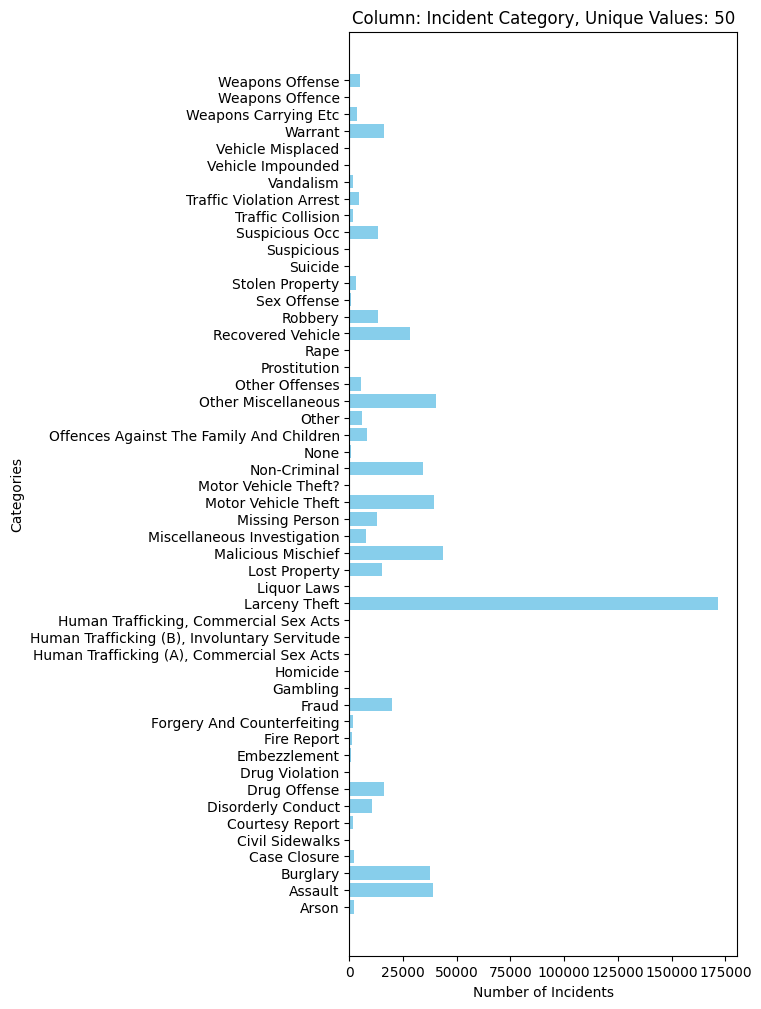

Column: Incident Description, Unique Values: 813
Column: Resolution, Unique Values: 4
[('Open or Active', 498220), ('Cite or Arrest Adult', 109692), ('Unfounded', 2446), ('Exceptional Adult', 1703)]


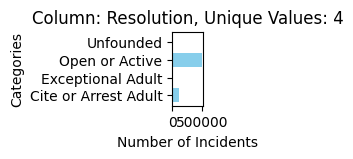

Column: Neighborhoods, Unique Values: 117
[(32, 55589), (None, 44603), (53, 44537), (20, 41068), (21, 17902), (19, 16813), (86, 13494), (99, 11739), (39, 11602), (50, 11411), (97, 11134), (54, 11092), (17, 10522), (8, 10163), (5, 10030), (106, 9242), (102, 8698), (108, 8527), (34, 8317), (83, 7677), (37, 7430), (107, 7288), (91, 6978), (16, 6189), (100, 5979), (88, 5329), (78, 5309), (87, 5251), (104, 5242), (40, 5201), (90, 5118), (103, 4953), (109, 4883), (101, 4732), (9, 4549), (22, 4459), (28, 4456), (84, 4444), (15, 4400), (75, 4318), (77, 4306), (26, 4266), (80, 4230), (94, 4094), (33, 4040), (105, 3967), (42, 3939), (56, 3904), (38, 3780), (52, 3652), (23, 3606), (98, 3556), (25, 3520), (41, 3198), (30, 2960), (31, 2901), (12, 2874), (24, 2686), (44, 2651), (112, 2628), (58, 2581), (64, 2482), (115, 2421), (85, 2337), (36, 2243), (81, 2242), (18, 2212), (66, 2193), (55, 2091), (95, 2071), (51, 2049), (74, 2009), (11, 1908), (14, 1908), (65, 1894), (13, 1864), (61, 1848), (82, 18

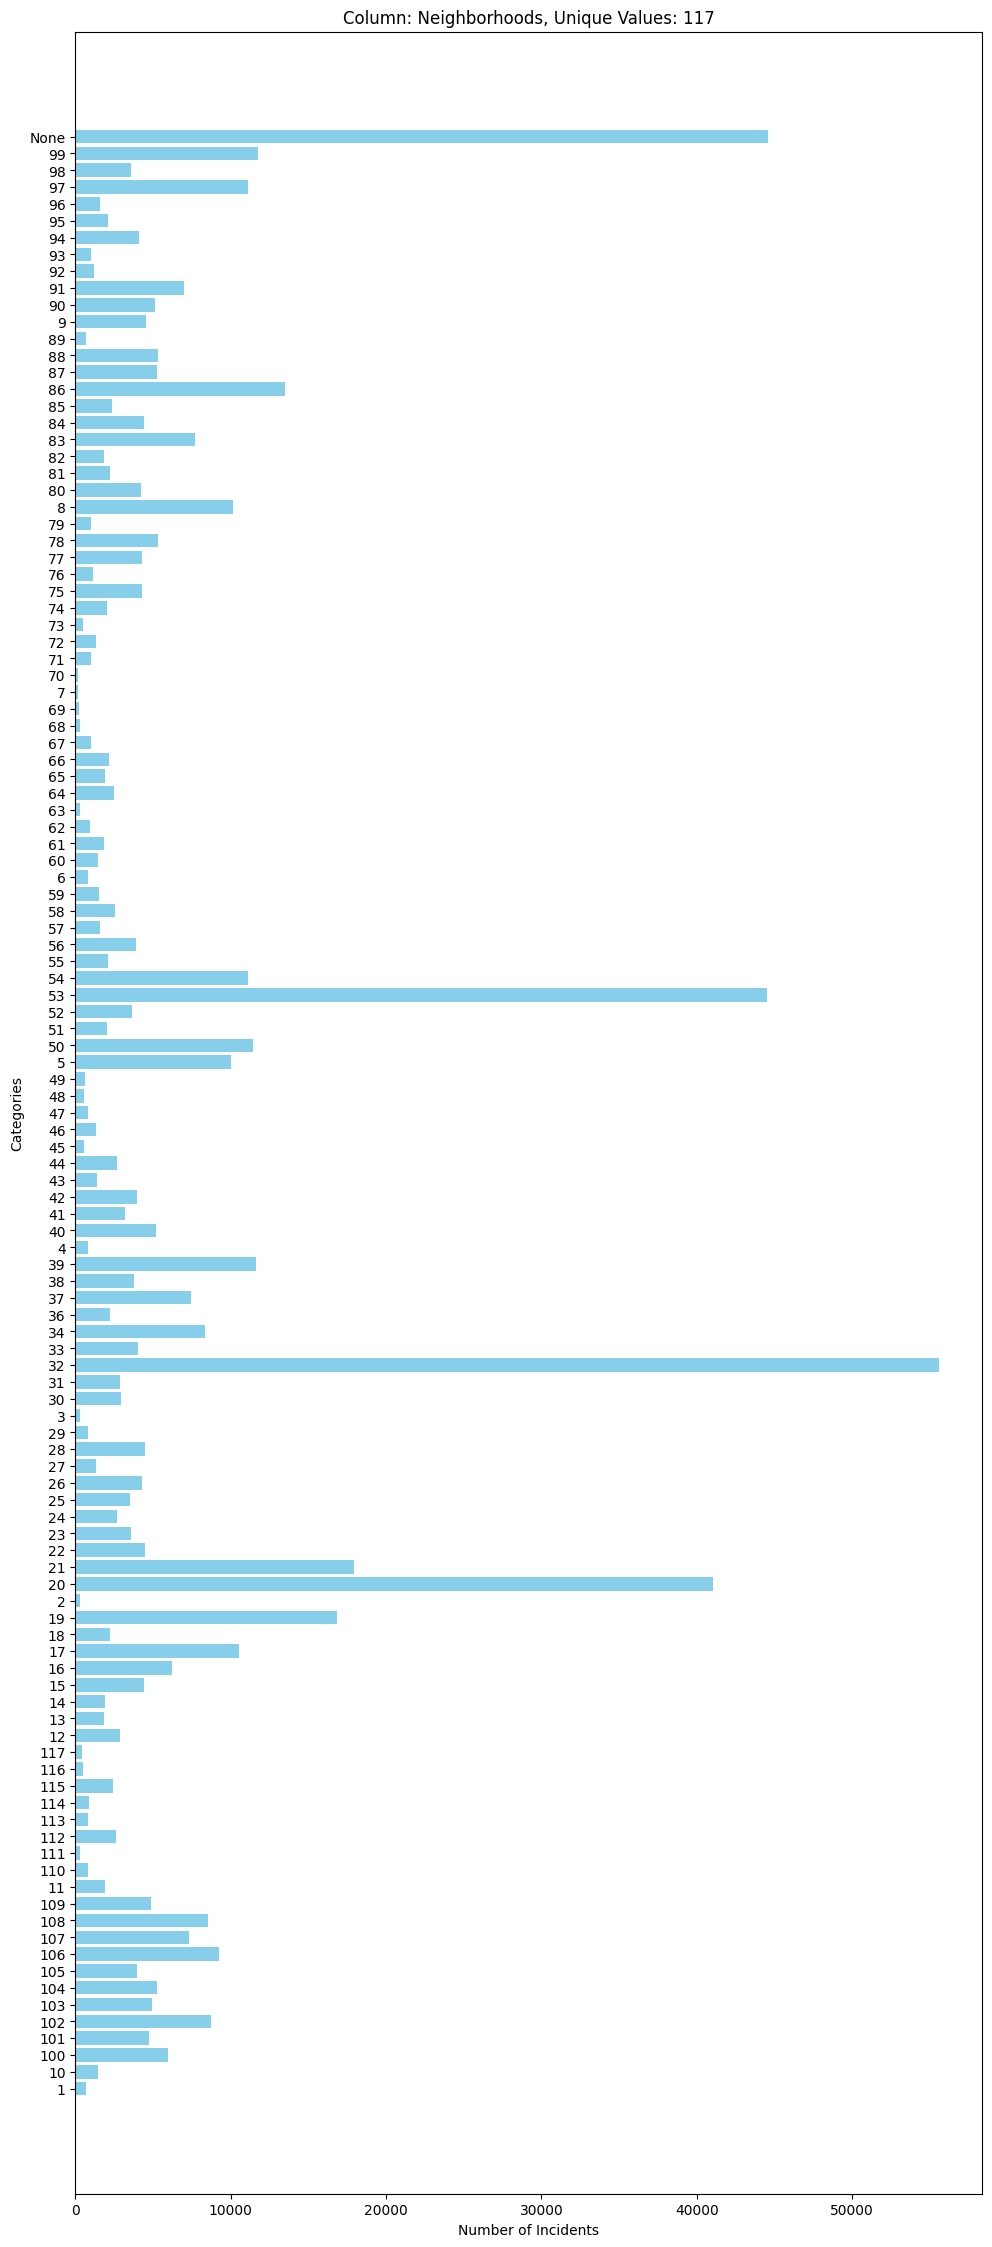

Column: Current Supervisor Districts, Unique Values: 12
[(10, 137426), (3, 78069), (9, 66533), (11, 58475), (2, 57181), (6, 45036), (5, 42702), (None, 33873), (4, 27362), (8, 25448), (1, 23078), (7, 16878)]
hey


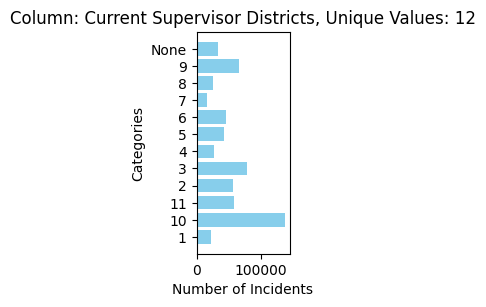

Column: Current Police Districts, Unique Values: 11
[(4, 83137), (6, 81440), (3, 72385), (1, 71870), (5, 57972), (2, 57744), (9, 48750), (10, 45534), (None, 34266), (8, 33675), (7, 25288)]
hey


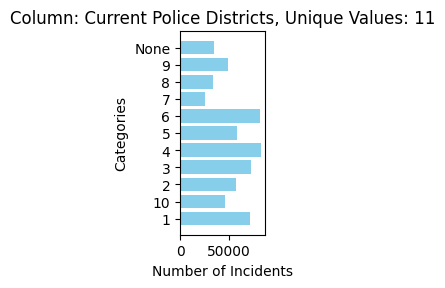

Column: Supervisor District, Unique Values: 12
[(6, 92481), (5, 91414), (3, 86277), (9, 65914), (10, 60071), (2, 42862), (8, 38915), (None, 34077), (7, 28949), (11, 26596), (1, 26221), (4, 18284)]
hey


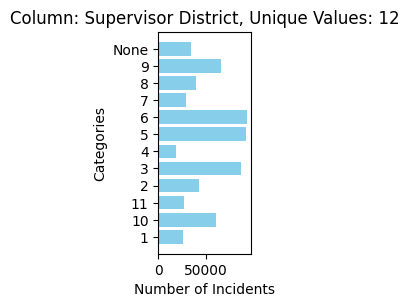

Column: Supervisor District 2012, Unique Values: 12
[(6, 137426), (3, 78069), (10, 66533), (5, 58475), (9, 57181), (2, 45036), (8, 42702), (None, 33873), (1, 27362), (7, 25448), (11, 23078), (4, 16878)]
hey


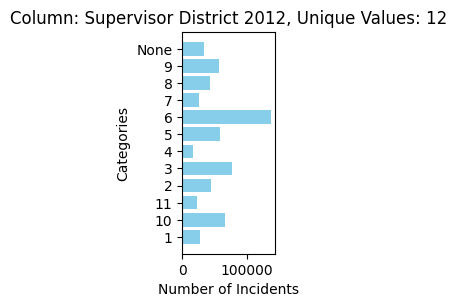

Column: Intersection, Unique Values: 9522
Column: Police District, Unique Values: 11
[('Central', 85822), ('Northern', 82530), ('Mission', 73365), ('Southern', 70627), ('Tenderloin', 62169), ('Bayview', 57132), ('Ingleside', 49924), ('Taraval', 44514), ('Richmond', 38325), ('Park', 26931), ('Out of SF', 20722)]


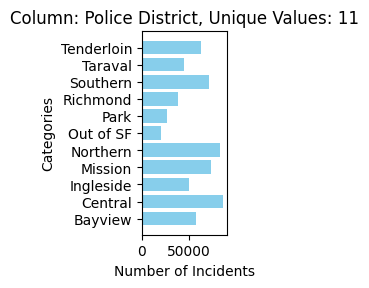

Column: Analysis Neighborhood, Unique Values: 43
[('Tenderloin', 62630), ('Mission', 59701), ('South of Market', 47275), ('Bayview Hunters Point', 41445), ('Financial District/South Beach', 39551), (None, 33795), ('Western Addition', 19132), ('North Beach', 18775), ('Sunset/Parkside', 17846), ('Marina', 16929), ('Nob Hill', 16840), ('Castro/Upper Market', 15780), ('Hayes Valley', 15705), ('Russian Hill', 13575), ('Outer Richmond', 13191), ('Bernal Heights', 12061), ('West of Twin Peaks', 11945), ('Pacific Heights', 10762), ('Excelsior', 10721), ('Chinatown', 10436), ('Mission Bay', 10392), ('Potrero Hill', 9823), ('Outer Mission', 9068), ('Haight Ashbury', 8881), ('Lakeshore', 7847), ('Inner Sunset', 7777), ('Inner Richmond', 7587), ('Noe Valley', 7303), ('Lone Mountain/USF', 7249), ('Portola', 7087), ('Visitacion Valley', 6502), ('Oceanview/Merced/Ingleside', 6458), ('Golden Gate Park', 5983), ('Japantown', 5547), ('Presidio Heights', 4033), ('Glen Park', 3493), ('Twin Peaks', 2864), 

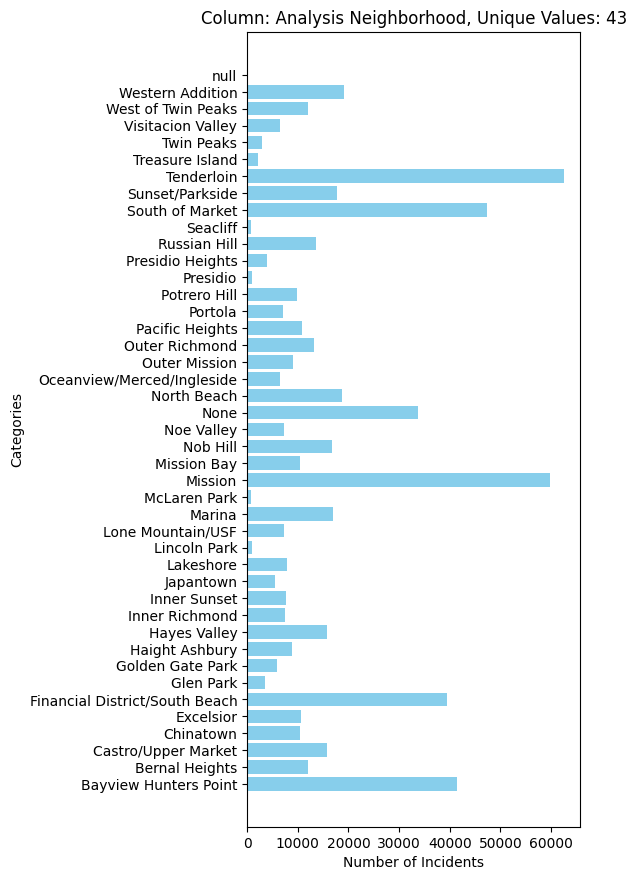

Column: Latitude, Unique Values: 12135
Column: Longitude, Unique Values: 11711


In [ ]:
unique_values_counts_per_value = {}

for city, columns in unique_values_counts.items():
    print(city)
    unique_values_counts_per_value[city] = {}

    print(f"City {city} is show_distinct_values")
    # show_distinct_values(filtered_dfs[city])

    df = filtered_dfs[city]

    for column, unique_values_count in columns.items():

        print(f"Column: {column}, Unique Values: {unique_values_count}")

        if unique_values_count < 150:

            value_counts = filtered_dfs[city].groupBy(column).count().orderBy("count", ascending=False).collect()

            items = [(row[column], row["count"]) for row in value_counts]
            print(items)
            if None in [row[column] for row in value_counts]:
                print("hey")

            items = [(str(row[column]), row["count"]) for row in value_counts]
            items.sort()
            labels, counts = zip(*items)

            plt.figure(figsize=(15 * (unique_values_count / 150), 36 * (unique_values_count / 150)))
            plt.barh(labels, counts, color='skyblue')
            plt.xlabel('Number of Incidents')
            plt.ylabel('Categories')
            plt.title(f"Column: {column}, Unique Values: {unique_values_count}")
            plt.show()


In [ ]:
from pyspark.sql.functions import countDistinct, col


def show_df_with_types(df, columns):
    formatted_columns = [f"{c} ({dtype})" for c, dtype in columns]
    df.toDF(*formatted_columns).show(truncate=False)


def show_distinct_values(df):
    # Compute distinct value counts for each column
    distinct_counts = df.agg(
        *[countDistinct(col(c)).alias(c) for c in df.columns]
    )

    # Show the distinct counts
    print("Distinct counts for each column:")
    show_df_with_types(distinct_counts, df.dtypes)

    # For each column, display unique value counts if unique values < 1000
    for column in df.columns:
        unique_count = distinct_counts.collect()[0][column]
        print(f"\nColumn '{column}' has {unique_count} unique values.")

        k = 1200
        if unique_count < k:
            print(f"Displaying counts for unique values in column '{column}' (ordered by column value):")
            value_counts = df.groupBy(column).count().orderBy(column)
            # value_counts.show(k, truncate=False)

            formatted_columns = [f"{c} ({dtype})" for c, dtype in value_counts.dtypes]
            value_counts.toDF(*formatted_columns).show(k, truncate=False)

# Iterate through city DataFrames and apply the function
for city in filtered_dfs.keys():
    print(f"\nCity: {city}")
    show_distinct_values(filtered_dfs[city])

In [ ]:
def change_nulls(df):


    for column in df.columns:
        df = df.withColumn(column,
                            when(
                                col(column).isNull() |
                                (trim(col(column)) == "") |
                                (trim(col(column)) == "-") |
                                (lower(trim(col(column)))).contains("none") |
                                (lower(trim(col(column)))).contains("null"), ""
                            ).otherwise(col(column))
                          )
    return df

In [ ]:
from pyspark.sql.functions import col, concat_ws, regexp_replace

renamed_dfs = {}

city = "new_york_file"
renamed_dfs[city] = change_nulls(filtered_dfs[city])

renamed_dfs[city] = renamed_dfs[city].withColumn("city", lit("New York"))
show_df_with_types(renamed_dfs[city], renamed_dfs[city].dtypes)
# renamed_dfs[city].show(n=5, truncate=False)

renamed_dfs[city] = renamed_dfs[city].select(

    col("city"),
    date_format(to_date(col("CMPLNT_FR_DT"), "MM/dd/yyyy"), "dd.MM.yyyy").alias("date_occured"),
    date_format(col("CMPLNT_FR_TM").substr(1, 5), "HH:mm").alias("time_occured"),
    date_format(to_date(col("CMPLNT_FR_DT"), "MM/dd/yyyy"), "dd.MM.yyyy").alias("date_report"),

    lit("").alias("time_report"),
    lit("").alias("crime_category"),
    col("OFNS_DESC").alias("crime_description"),

    col("Latitude").alias("latitude"),
    col("Longitude").alias("longitude"),


    lit("").alias("address"),
    col('PREM_TYP_DESC').alias("location_type"),
    lit("").alias("investigation_status"),

    when(col("VIC_AGE_GROUP").isin(["18-24", "25-44", "45-64", "65+", "<18"]), col("VIC_AGE_GROUP"))
      .when(col("VIC_AGE_GROUP").isNull() | (lower(col("VIC_AGE_GROUP")) ).contains("null"), "")
      .otherwise("").alias("victim_age_group"),

    when(col("VIC_SEX") == "F", "F")
      .when(col("VIC_SEX") == "M", "M")
      # .when(col("SUSP_SEX") == "U", "UNKNOWN")
      .otherwise("").alias("victim_sex"),

    when(
        col("VIC_RACE").isNull() | (lower(col("SUSP_RACE")) ).contains("unknown") | (lower(col("VIC_RACE")) ).contains("null"), "")
      .otherwise(col("VIC_RACE")).alias("victim_race"),


    when(col("SUSP_AGE_GROUP").isin(["18-24", "25-44", "45-64", "65+", "<18"]), col("SUSP_AGE_GROUP"))
      .when(col("SUSP_AGE_GROUP").isNull() | (lower(col("SUSP_AGE_GROUP")) ).contains("null"), "")
      .otherwise("").alias("suspect_age_group"),


    when(col("SUSP_SEX") == "F", "F")
      .when(col("SUSP_SEX") == "M", "M")
      # .when(col("SUSP_SEX") == "U", "UNKNOWN")
      .otherwise("").alias("suspect_sex"),

    when(col("SUSP_RACE").isNull() | (lower(col("SUSP_RACE")) ).contains("unknown") | (lower(col("SUSP_RACE")) ).contains("null"), "")
      .otherwise(col("SUSP_RACE")).alias("suspect_race"),


    concat_ws(" ", col("city"), regexp_replace(col("PATROL_BORO"), "^PATROL BORO ", "")).alias("police_station")

)
renamed_dfs[city] = change_nulls(renamed_dfs[city])
show_df_with_types(renamed_dfs[city], renamed_dfs[city].dtypes)
# renamed_dfs[city].show(n=5, truncate=False)


+---------------------+---------------------+---------------+--------------+------------------------------+--------------------+----------------+-------------------------+---------------------------+-------------------------+-----------------+------------------+----------------------+------------------------+----------------+-----------------------+------------------------+-----------------+-------------+
|CMPLNT_FR_DT (string)|CMPLNT_FR_TM (string)|RPT_DT (string)|KY_CD (string)|OFNS_DESC (string)            |ADDR_PCT_CD (string)|BORO_NM (string)|PATROL_BORO (string)     |PREM_TYP_DESC (string)     |CRM_ATPT_CPTD_CD (string)|Latitude (string)|Longitude (string)|VIC_AGE_GROUP (string)|VIC_RACE (string)       |VIC_SEX (string)|SUSP_AGE_GROUP (string)|SUSP_RACE (string)      |SUSP_SEX (string)|city (string)|
+---------------------+---------------------+---------------+--------------+------------------------------+--------------------+----------------+-------------------------+-----------

In [ ]:
show_distinct_values(renamed_dfs["new_york_file"])

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+

In [ ]:
show_distinct_values(filtered_dfs["san_francisco_file"])

Distinct counts for each column:
+-----------------+---------------+-------------+-----------------+--------------------+----------+-------------+----------------------------+------------------------+-------------------+------------------------+------------+---------------+---------------------+--------+---------+
|Incident Datetime|Report Datetime|Incident Code|Incident Category|Incident Description|Resolution|Neighborhoods|Current Supervisor Districts|Current Police Districts|Supervisor District|Supervisor District 2012|Intersection|Police District|Analysis Neighborhood|Latitude|Longitude|
+-----------------+---------------+-------------+-----------------+--------------------+----------+-------------+----------------------------+------------------------+-------------------+------------------------+------------+---------------+---------------------+--------+---------+
|298050           |438473         |815          |49               |813                 |4         |116          |11   

In [ ]:
city = "san_francisco_file"
renamed_dfs[city] = change_nulls(filtered_dfs[city])
renamed_dfs[city] = renamed_dfs[city].withColumn("city", lit("San Francisco"))
renamed_dfs[city] = renamed_dfs[city].select(

    col("city"),
    date_format(to_timestamp(col("Incident Datetime"), "yyyy/MM/dd hh:mm:ss a"), "dd.MM.yyyy").alias("date_occured"),
    date_format(to_timestamp(col("Incident Datetime"), "yyyy/MM/dd hh:mm:ss a"), "HH:mm").alias("time_occured"),

    date_format(to_timestamp(col("Report Datetime"), "yyyy/MM/dd hh:mm:ss a"), "dd.MM.yyyy").alias("date_report"),
    date_format(to_timestamp(col("Report Datetime"), "yyyy/MM/dd hh:mm:ss a"), "HH:mm").alias("time_report"),

    col("Incident Category").alias("crime_category"),
    col("Incident Description").alias("crime_description"),

    col("Latitude").alias("latitude"),
    col("Longitude").alias("longitude"),

    col("Intersection").alias("address"),
    lit("").alias("location_type"),
    when(col("Resolution").isin("Open or Active"), "not finished")
    .otherwise("finished").alias("investigation_status"),

    lit("").alias("victim_age_group"),
    lit("").alias("victim_sex"),
    lit("").alias("victim_race"),
    concat_ws(" ", col("city"), col("Police District")).alias("police_station")

)
renamed_dfs[city] = change_nulls(renamed_dfs[city])
renamed_dfs[city].show(truncate=False)


+-------------+------------+------------+-----------+-----------+-----------------+----------------------------------------------------+------------------+-------------------+---------------------+-------------+--------------------+----------------+----------+-----------+-----------------------+
|city         |date_occured|time_occured|date_report|time_report|crime_category   |crime_description                                   |latitude          |longitude          |address              |location_type|investigation_status|victim_age_group|victim_sex|victim_race|police_station         |
+-------------+------------+------------+-----------+-----------+-----------------+----------------------------------------------------+------------------+-------------------+---------------------+-------------+--------------------+----------------+----------+-----------+-----------------------+
|San Francisco|13.03.2023  |23:41       |13.03.2023 |23:41      |Recovered Vehicle|Vehicle, Recovered, Auto  

In [ ]:
show_distinct_values(renamed_dfs["san_francisco_file"])

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+------

In [ ]:
# Функція для перевірки пропусків у всіх колонках
def check_missing_values(df, name):
    print(f"Пропуски в {name}:")
    df.select([(df[col].isNull().alias(col)) for col in df.columns]).groupBy().sum().show()

detroit_df = filtered_dfs["detroit_file"]
la_df = filtered_dfs["los_angeles_file"]
check_missing_values(detroit_df, "Detroit")
check_missing_values(la_df, "Los Angeles")

# Перевірка типів даних
print("Типи даних Detroit:")
detroit_df.printSchema()

print("\nТипи даних Los Angeles:")
la_df.printSchema()


Пропуски в Detroit:
++
||
++
||
++

Пропуски в Los Angeles:
++
||
++
||
++

Типи даних Detroit:
root
 |-- incident_occurred_at: string (nullable = true)
 |-- offense_category: string (nullable = true)
 |-- offense_description: string (nullable = true)
 |-- state_offense_code: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- nearest_intersection: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- police_precinct: string (nullable = true)
 |-- council_district: integer (nullable = true)
 |-- neighborhood: string (nullable = true)


Типи даних Los Angeles:
root
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true

In [ ]:
detroit_df = detroit_df.withColumn("city", lit("Detroit"))
la_df = la_df.withColumn("city", lit("Los Angeles"))

# Detroit
detroit_normalized = detroit_df.select(
    col("city").alias("city"),
    date_format(to_date(col("incident_occurred_at").substr(1, 10), "yyyy/MM/dd"), "dd.MM.yyyy").alias("date_occured"),
    date_format(col("incident_occurred_at").substr(12, 5), "HH:mm").alias("time_occured"),
    lit('').alias("date_report"),
    lit('').alias("time_report"),
    col("offense_category").alias("crime_category"),
    col("offense_description").alias("crime_description"),
    col("latitude"),
    col("longitude"),
    col("nearest_intersection").alias("address"),
    lit('').alias("Location_type"),
    when(col("case_status").isin("INACTIVE", "ACTIVE"), "not finished").otherwise("finished").alias("Investigation_status"),
    lit('').alias("victim_age_group"),
    lit('').alias("victim_sex"),
    lit('').alias("victim_race"),
    concat_ws(" ", col("city"), col("police_precinct")).alias("police_station")
)
detroit_normalized = detroit_normalized.fillna('')
detroit_normalized.show(5)
detroit_df.show(5)

+-------+------------+------------+-----------+-----------+------------------+--------------------+----------------+-----------------+--------------------+-------------+--------------------+----------------+----------+-----------+--------------+
|   city|date_occured|time_occured|date_report|time_report|    crime_category|   crime_description|        latitude|        longitude|             address|Location_type|Investigation_status|victim_age_group|victim_sex|victim_race|police_station|
+-------+------------+------------+-----------+-----------+------------------+--------------------+----------------+-----------------+--------------------+-------------+--------------------+----------------+----------+-----------+--------------+
|Detroit|  25.10.2022|       20:00|           |           |    STOLEN VEHICLE| MOTOR VEHICLE THEFT|42.4382753656854|-83.0528961345903|Conley St & E Lan...|             |        not finished|                |          |           |    Detroit 11|
|Detroit|  11.06

In [ ]:
show_distinct_values(detroit_normalized)

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (double)|longitude (double)|address (string)|Location_type (string)|Investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+------

In [ ]:
#Прибираємо аномальні значення
la_normalized = la_df.filter((col("Vict Age") >= 0) & (col("Vict Age") <= 120))

#LA
la_normalized = la_normalized.select(
    col("city").alias("city"),
    date_format(to_timestamp(col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a"), "dd.MM.yyyy").alias("date_occured"),
    concat_ws(":",
              lpad((col("TIME OCC") / 100).cast("int").cast("string"), 2, "0"),
              lpad((col("TIME OCC") % 100).cast("int").cast("string"), 2, "0")
    ).alias("time_occured"),
    date_format(to_timestamp(col("Date Rptd"), "MM/dd/yyyy hh:mm:ss a"), "dd.MM.yyyy").alias("date_report"),
    lit('').alias("time_report"),
    lit('').alias("crime_category"),
    col("Crm Cd Desc").alias("crime_description"),
    col("LAT").alias("latitude"),
    col("LON").alias("longitude"),
    regexp_replace(col("LOCATION"), r"\s+\d+$", "").alias("address"),
    col("Premis Desc").alias("location_type"),
    when(col("Status Desc") == "Invest Cont", "not finished").otherwise("finished").alias("investigation_status"),
    when((col("Vict Age") >= 1) & (col("Vict Age") < 18), "<18")
    .when((col("Vict Age") >= 18) & (col("Vict Age") <= 24), "18-24")
    .when((col("Vict Age") >= 25) & (col("Vict Age") <= 44), "25-44")
    .when((col("Vict Age") >= 45) & (col("Vict Age") <= 64), "45-64")
    .when((col("Vict Age") >= 65) & (col("Vict Age") <= 120), "65+")
    .otherwise("").alias("victim_age_group"),

    when(col("Vict Sex") == "M", "M")
    .when(col("Vict Sex") == "F", "F")
    # .when(col("Vict Sex") == "X", "UNKNOWN")
    .otherwise("").alias("victim_sex"),

    when(col("Vict Descent") == "X", "") #UNKNOWN
    .when(col("Vict Descent").isin("B"), "BLACK")
    .when(col("Vict Descent").isin("W"), "WHITE")
    .when(col("Vict Descent").isin("H"), "WHITE HISPANIC")
    .when(col("Vict Descent").isNull() | (col("Vict Descent") == "-") | (col("Vict Descent") == "") | (lower(col("Vict Descent"))).contains("null"), "")
    .when(col("Vict Descent").isin("A", "C", "D", "F", "G", "J", "K", "L", "P", "S", "U", "V", "Z"), "ASIAN / PACIFIC ISLANDER")
    .when(col("Vict Descent").isin("I"), "AMERICAN INDIAN/ALASKAN NATIVE")
    .otherwise("OTHER").alias("victim_race"),
    concat_ws(" ", col("City"), col("AREA")).alias("police_station") #AREA NAME
)
la_normalized = la_normalized.fillna('')
la_normalized.show(5)
la_df.show(5)

+-----------+------------+------------+-----------+-----------+--------------+--------------------+--------+---------+--------------------+--------------------+--------------------+----------------+----------+--------------+--------------+
|       city|date_occured|time_occured|date_report|time_report|crime_category|   crime_description|latitude|longitude|             address|       location_type|investigation_status|victim_age_group|victim_sex|   victim_race|police_station|
+-----------+------------+------------+-----------+-----------+--------------+--------------------+--------+---------+--------------------+--------------------+--------------------+----------------+----------+--------------+--------------+
|Los Angeles|  24.11.2022|       18:20| 24.11.2022|           |              |ASSAULT WITH DEAD...| 33.9833|-118.2696|6200 S  SAN PEDRO...|         PARKING LOT|        not finished|           45-64|         F|WHITE HISPANIC|Los Angeles 13|
|Los Angeles|  02.01.2022|       00:15| 

In [ ]:
# show_distinct_values(renamed_dfs["detroit_file"])
show_distinct_values(la_normalized)



Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (double)|longitude (double)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+------

KeyError: 'los_angeles_file'

In [ ]:
city = "detroit_file"
renamed_dfs[city] = change_nulls(detroit_normalized)
show_distinct_values(renamed_dfs[city])

city = "los_angeles_file"
renamed_dfs[city] = change_nulls(la_normalized)
show_distinct_values(renamed_dfs[city])


required_columns = {
    "suspect_sex": "",
    "suspect_age_group": "",
    "suspect_race": ""
}

# Ensure all required columns are present in each DataFrame
for city in renamed_dfs.keys():
    for column, default_value in required_columns.items():
        if column not in renamed_dfs[city].columns:
            renamed_dfs[city] = renamed_dfs[city].withColumn(column, lit(default_value))


Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|Location_type (string)|Investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+------

In [ ]:
for city in renamed_dfs.keys():
    # renamed_dfs[city].show(n=5)
    print(city)
    show_distinct_values(renamed_dfs[city])


new_york_file
Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+----------

In [ ]:
list_of_silver_dfs = list(renamed_dfs.items())

silver_name, total_silver_df = list_of_silver_dfs[0]
print(f"Spart merging files: first one {silver_name}")

for silver_name, silver_df in list_of_silver_dfs[1:]:
    print(f"Merging {silver_name}")
    total_silver_df = total_silver_df.unionByName(silver_df)

output_path = "/content/drive/MyDrive/big_data_project/silver_data/combined_crime_incidents_data"
# total_silver_df.write.parquet(output_path, header=True, mode="overwrite")
total_silver_df.write.parquet(output_path, mode="overwrite")

Spart merging files: first one new_york_file
Merging san_francisco_file
Merging detroit_file
Merging los_angeles_file


In [ ]:
def save_unique_values_of_each_column(df, city_name):

    file_path = file_paths[city_name]
    path, filename = os.path.split(file_path)
    path = os.path.join(path, city_name)
    filename, extention = os.path.splitext(filename)


    os.makedirs(path, exist_ok=True)

    for col_name in df.columns:
        df.select(col_name).distinct().write.mode("overwrite").csv(f"{path}/{col_name}")


# for city in file_dfs.keys():
#     print(f"Save list of unique values of {city}")
#     save_unique_values_of_each_column(file_dfs[city], city)

City san_fransisko_file is trimming
City new_york_file is checking


In [ ]:
# merged data
output_path = "/content/drive/MyDrive/big_data_project/silver_data/combined_crime_incidents_data"

merged_df = spark.read.parquet(output_path)
merged_df.show(truncate=False)
print(f"File merged_df is read")


+--------+------------+------------+-----------+-----------+--------------+------------------------------+-----------+------------+-------+---------------------------+--------------------+----------------+----------+------------------------+-----------------+-----------+------------------------+----------------------+
|city    |date_occured|time_occured|date_report|time_report|crime_category|crime_description             |latitude   |longitude   |address|location_type              |investigation_status|victim_age_group|victim_sex|victim_race             |suspect_age_group|suspect_sex|suspect_race            |police_station        |
+--------+------------+------------+-----------+-----------+--------------+------------------------------+-----------+------------+-------+---------------------------+--------------------+----------------+----------+------------------------+-----------------+-----------+------------------------+----------------------+
|New York|01.01.2020  |00:46       |01.0

In [ ]:
show_distinct_values(merged_df)

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+

In [ ]:
from pyspark.sql.functions import upper

merged_df = merged_df.withColumn('crime_category', upper(merged_df['crime_category']))
merged_df = merged_df.withColumn('crime_description', upper(merged_df['crime_description']))

#Опрацювання crime_category
def merge_crimes(merged_df, column_name):
    if column_name not in ["crime_category", "crime_description"]:
        raise ValueError(' merge_crimes(column_name): column_name not in ["crime_category", "crime_description"]')

    merged_df = merged_df.withColumn(column_name, trim(merged_df[column_name]))
    merged_df = merged_df.withColumn(column_name,
        when(col(column_name).like("LARCENY%"), "LARCENY/THEFT")
        .when(col(column_name).like("MOTOR VEHICLE THEFT%"), "VEHICLE THEFT")
        .when(col(column_name).like("STOLEN VEHICLE%"), "VEHICLE THEFT")
        .when(col(column_name).like("AGGRAVATED ASSAULT%"), "ASSAULT")
        .when(col(column_name).like("SEX OFFENSE%"), "SEX OFFENSES")
        .when(col(column_name).like("SEX OFFENSES%"), "SEX OFFENSES")
        .when(col(column_name).like("SEXUAL ASSAULT%"), "SEX OFFENSES")
        .when(col(column_name).like("WEAPONS OFFENSES%"), "WEAPONS OFFENSE")
        .when(col(column_name).like("WEAPONS OFFENSE%"), "WEAPONS OFFENSE")
        .when(col(column_name).like("WEAPONS OFFENSES%"), "WEAPONS OFFENSE")
        .when(col(column_name).like("WEAPONS OFFENCE%"), "WEAPONS OFFENSE")
        .when(col(column_name).like("MISCELLANEOUS INVESTIGATION%"), "MISCELLANEOUS")
        .when(col(column_name).like("SUSPICIOUS OCC%"), "SUSPICIOUS")
        .when(col(column_name).like("TRAFFIC COLLISION%"), "TRAFFIC VIOLATION")
        .when(col(column_name).like("TRAFFIC VIOLATION ARREST%"), "TRAFFIC VIOLATION")
        .when(col(column_name).like("VEHICLE IMPOUNDED%"), "OTHER")
        .when(col(column_name).like("COURTESY REPORT%"), "OTHER")
        .when(col(column_name).like("CASE CLOSURE%"), "OTHER")
        .when(col(column_name).like("OBSTRUCTING THE POLICE%"), "OBSTRUCTION")
        .when(col(column_name).like("OBSTRUCTING JUDICIARY%"), "OBSTRUCTION")
        .when(col(column_name).like("VEHICLE MISPLACED%"), "OTHER")
        .when(col(column_name).like("NULL%"), "")
        .when(col(column_name).like("OTHER OFFENSES%"), "OTHER")
        .when(col(column_name).like("MISCELLANEOUS%"), "MISCELLANEOUS")
        .when(col(column_name).like("OTHER MISCELLANEOUS%"), "MISCELLANEOUS")
        .when(col(column_name).like("LIQUOR%"), "LIQUOR")
        .when(col(column_name).like("LIQUOR LAWS%"), "LIQUOR")
        .when(col(column_name).like("FORGERY AND COUNTERFEITING%"), "FORGERY AND COUNTERFEITING")
        .when(col(column_name).like("FORGERY%"), "FORGERY AND COUNTERFEITING")
        .when(col(column_name).like("DRUG OFFENSE%"), "DRUG OFFENSE")
        .when(col(column_name).like("DRUG VIOLATION%"), "DRUG OFFENSE")
        .when(col(column_name).like("DANGEROUS DRUGS%"), "DRUG OFFENSE")
        .when(col(column_name).like("NON-CRIMINAL%"), "NON-CRIMINAL")
        .when(col(column_name).like("CIVIL SIDEWALKS%"), "NON-CRIMINAL")
        .when(col(column_name).like("OUIL%"), "DRUNK DRIVING")
        .when(col(column_name).like("HUMAN TRAFFICKING%"), "HUMAN TRAFFICKING")
        .when(col(column_name).like("HUMAN TRAFFICKING, COMMERCIAL SEX ACTS%"), "HUMAN TRAFFICKING")
        .when(col(column_name).like("HUMAN TRAFFICKING (B), INVOLUNTARY SERVITUDE%"), "HUMAN TRAFFICKING")
        .when(col(column_name).like("HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS%"), "HUMAN TRAFFICKING")
        .when(col(column_name).like("HOMICIDE%"), "HOMICIDE")
        .when(col(column_name).like("JUSTIFIABLE HOMICIDE%"), "HOMICIDE")
        .otherwise(col(column_name))
    )
    merged_df = merged_df.na.fill({column_name: ""})
    return merged_df

merged_df = merge_crimes(merged_df, "crime_category")

In [ ]:
merged_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- date_occured: string (nullable = true)
 |-- time_occured: string (nullable = true)
 |-- date_report: string (nullable = true)
 |-- time_report: string (nullable = true)
 |-- crime_category: string (nullable = false)
 |-- crime_description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- address: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- investigation_status: string (nullable = true)
 |-- victim_age_group: string (nullable = true)
 |-- victim_sex: string (nullable = true)
 |-- victim_race: string (nullable = true)
 |-- suspect_age_group: string (nullable = true)
 |-- suspect_sex: string (nullable = true)
 |-- suspect_race: string (nullable = true)
 |-- police_station: string (nullable = true)



In [ ]:
show_distinct_values(merged_df)

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+

"""Experiments"""

In [ ]:
merged_df = merge_crimes(merged_df, "crime_description")
show_distinct_values(merged_df)

Distinct counts for each column:
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (string)|time_occured (string)|date_report (string)|time_report (string)|crime_category (string)|crime_description (string)|latitude (string)|longitude (string)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+---------------------+---------------------+--------------------+--------------------+-----------------------+

In [ ]:
column_name = "crime_description"
crime_description_df = merged_df.select(column_name).distinct()
# show_distinct_values(crime_description_df)


crime_description_df = crime_description_df.withColumn(column_name, trim(crime_description_df[column_name]))
crime_description_df = crime_description_df.withColumn(column_name,
    when(col(column_name).like("ACCESS CARD%"), "ACCESS CARD")
    .when(col(column_name).like("ACCIDENT%"), "ACCIDENT")
    .when(col(column_name).like("AIDED CASE%"), "AIDED CASE")
    .when(col(column_name).like("AGGRAVATED ASSAULT%"), "ASSAULT")
    .when(col(column_name).like("ALCOHOL%"), "ALCOHOL")
    .when(col(column_name).like("ANIMAL%"), "ANIMAL")
    .when(col(column_name).like("ARSON%"), "ARSON")
    .when(col(column_name).like("ASSAULT%"), "ASSAULT")
    .when(col(column_name).like("BATTERY%"), "BATTERY")
    .when(col(column_name).like("BURGLA%"), "BURGLAY")
    .when(col(column_name).like("CHECKS%"), "CHECKS")
    .when(col(column_name).like("CHILD%"), "CHILD")
    .when(col(column_name).like("COCAINE%"), "COCAINE")
    .when(col(column_name).like("CONTROLLED SUBSTANCE%"), "CONTROLLED SUBSTANCE")
    .when(col(column_name).like("COUNTERFEIT%"), "COUNTERFEIT")
    .when(col(column_name).like("CSC%"), "CSC")
    .when(col(column_name).like("DAMAGE%"), "DAMAGE")
    .when(col(column_name).like("DEATH%"), "DEATH")
    .when(col(column_name).like("DEFRAUDING%"), "DEFRAUDING")
    .when(col(column_name).like("DRIVING%"), "DRIVING")
    .when(col(column_name).like("DRUG%"), "DRUG")
    .when(col(column_name).like("EMBEZZLEMENT%"), "EMBEZZLEMENT")
    .when(col(column_name).like("ESCAPE%"), "ESCAPE")
    .when(col(column_name).like("FALSE%"), "FALSE")
    .when(col(column_name).like("FAMILY%"), "FAMILY")
    .when(col(column_name).like("FIRE%"), "FIRE")
    .when(col(column_name).like("FOUND%"), "FOUND")
    .when(col(column_name).like("FRAUD%"), "FRAUD")
    .when(col(column_name).like("MALICIOUS MISCHIEF%"), "MALICIOUS MISCHIEF")
    .when(col(column_name).like("MARIJUANA%"), "MARIJUANA")
    .when(col(column_name).like("ROBBERY%"), "ROBBERY")
    .when(col(column_name).like("SCHOOL%"), "SCHOOL")
    .when(col(column_name).like("SEX%"), "SEX")
    .when(col(column_name).like("SOLICITING%"), "SOLICITING")
    .when(col(column_name).like("STOLEN%"), "STOLEN")
    .when(col(column_name).like("SUICIDE%"), "SUICIDE")
    .when(col(column_name).like("SUSPICIOUS%"), "SUSPICIOUS")
    .when(col(column_name).like("THEFT%"), "THEFT")
    .when(col(column_name).like("VANDALISM%"), "VANDALISM")
    .when(col(column_name).like("VEHICLE%"), "VEHICLE")
    .when(col(column_name).like("VIOLATION%"), "VIOLATION")
    .when(col(column_name).like("WEAPON%"), "WEAPON")
    .otherwise(col(column_name))
)

show_distinct_values(crime_description_df)


Distinct counts for each column:
+--------------------------+
|crime_description (string)|
+--------------------------+
|505                       |
+--------------------------+


Column 'crime_description' has 505 unique values.
Displaying counts for unique values in column 'crime_description' (ordered by column value):
+------------------------------------------------------------------------------------+--------------+
|crime_description (string)                                                          |count (bigint)|
+------------------------------------------------------------------------------------+--------------+
|                                                                                    |1             |
|"FIREWORKS, POSSESSION OF ANY WITHIN SF,  INCL. ""SAFE & SANE"""                    |1             |
|ABORTION, UNLAWFUL                                                                  |1             |
|ACCESS CARD                                                     

In [ ]:
show_distinct_values(merged_df.filter(col("city") == "Los Angeles"))

In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, month, year, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
spark = SparkSession.builder.appName("CrimeAnalysis").getOrCreate()

# merged data from Arsen
folder_path = "/content/drive/MyDrive/big_data_project/silver_data/4_usa_city_crime_data/"

data = spark.read.csv(folder_path, header=True, inferSchema=True)

data.printSchema()

data = data.withColumn("date_occured", to_date(col("date_occured"), "dd.MM.yyyy")) \
           .withColumn("date_report", to_date(col("date_report"), "dd.MM.yyyy"))

data.show(15)
# unique_cities = data.select("city").distinct()

# unique_cities.show()

root
 |-- city: string (nullable = true)
 |-- date_occured: string (nullable = true)
 |-- time_occured: timestamp (nullable = true)
 |-- date_report: string (nullable = true)
 |-- time_report: timestamp (nullable = true)
 |-- crime_category: string (nullable = true)
 |-- crime_description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- address: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- investigation_status: string (nullable = true)
 |-- victim_age_group: string (nullable = true)
 |-- victim_sex: string (nullable = true)
 |-- victim_race: string (nullable = true)
 |-- suspect_age_group: string (nullable = true)
 |-- suspect_sex: string (nullable = true)
 |-- suspect_race: string (nullable = true)
 |-- police_station: string (nullable = true)

+--------+------------+-------------------+-----------+-----------+--------------+--------------------+-----------+------------+-------+---------------

In [ ]:
show_distinct_values(data)

Distinct counts for each column:
+-------------+-------------------+------------------------+------------------+-----------------------+-----------------------+--------------------------+-----------------+------------------+----------------+----------------------+-----------------------------+-------------------------+-------------------+--------------------+--------------------------+--------------------+---------------------+-----------------------+
|city (string)|date_occured (date)|time_occured (timestamp)|date_report (date)|time_report (timestamp)|crime_category (string)|crime_description (string)|latitude (double)|longitude (double)|address (string)|location_type (string)|investigation_status (string)|victim_age_group (string)|victim_sex (string)|victim_race (string)|suspect_age_group (string)|suspect_sex (string)|suspect_race (string)|police_station (string)|
+-------------+-------------------+------------------------+------------------+-----------------------+------------------

In [ ]:
data.count()

4378584

## Graphics

In [ ]:
data_hour = data.filter(col('time_occured').isNotNull()).withColumn("hour", hour("time_occured")).select("hour")
df_hour_count = data_hour.groupBy("hour") \
                  .agg(count("*").alias("count"))

<ipython-input-35-136ad8e2e91d>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="hour", y="count", data=pd_df, palette=colors, ci=None)
<ipython-input-35-136ad8e2e91d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hour", y="count", data=pd_df, palette=colors, ci=None)
<ipython-input-35-136ad8e2e91d>:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x="hour", y="count", data=pd_df, palette=colors, ci=None)


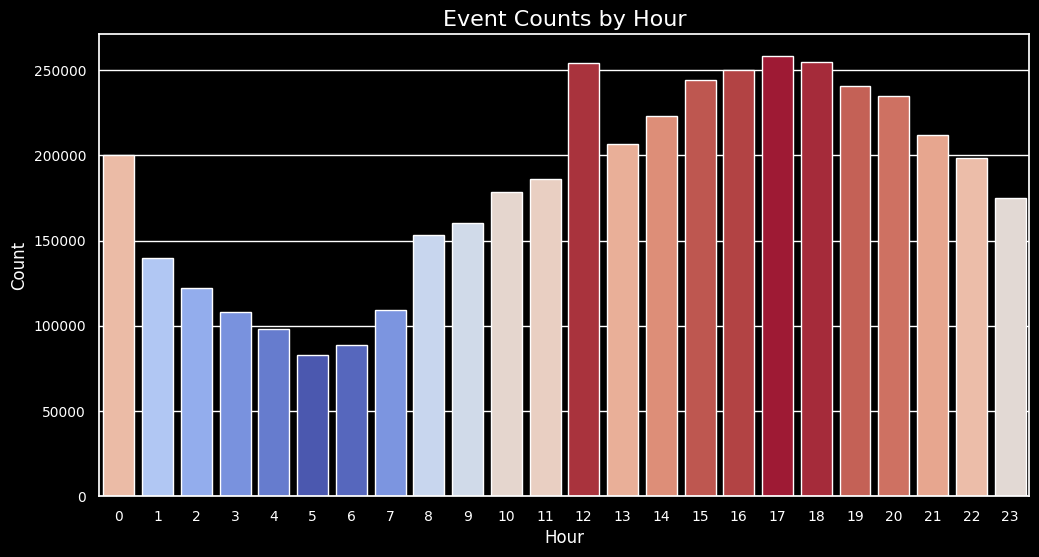

In [ ]:
pd_df = df_hour_count.orderBy("hour").toPandas()

# Normalize counts for color mapping
norm = plt.Normalize(pd_df["count"].min(), pd_df["count"].max())
colors = plt.cm.coolwarm(norm(pd_df["count"]))

# Set dark background theme
sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#333333", "figure.facecolor": "#333333"})
plt.style.use('dark_background')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="hour", y="count", data=pd_df, palette=colors, ci=None)

# Customize the plot
plt.title("Event Counts by Hour", color="white", fontsize=16)
plt.xlabel("Hour", color="white", fontsize=12)
plt.ylabel("Count", color="white", fontsize=12)
plt.xticks(color="white", fontsize=10)
plt.yticks(color="white", fontsize=10)
# plt.grid(color="gray", linestyle="--", linewidth=0.5)

# Show plot
plt.show()

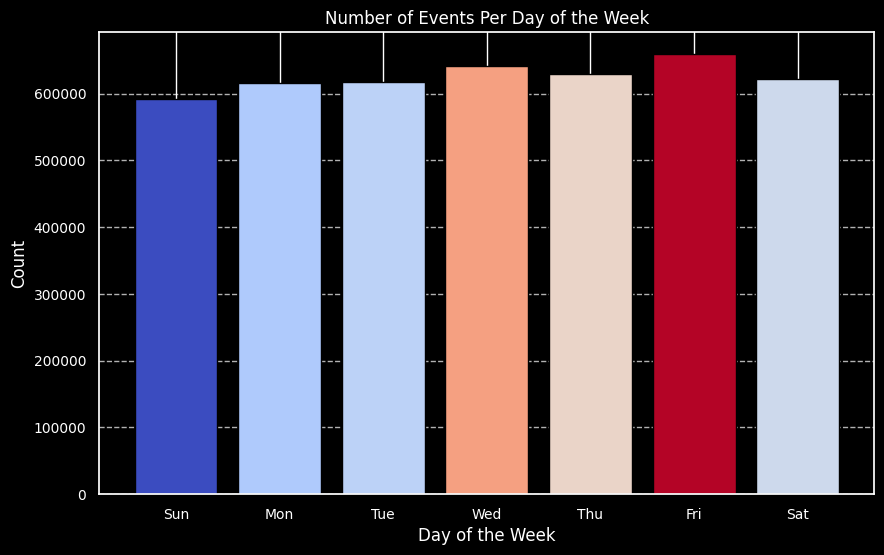

In [ ]:
# df_day_count = data.filter(col('date_occured').isNotNull() & (to_date(col('date_occured')) < "2023-09") & (to_date(col('date_occured')) >= "2023-05"))\
df_day_count = data.filter(col('date_occured').isNotNull())\
                 .withColumn("day_of_week", dayofweek("date_occured")) \
                 .groupBy("day_of_week") \
                 .agg(count("*").alias("count"))




df_day_count = df_day_count.withColumn(
    "day_name",
    when(col("day_of_week") == 1, lit("Sun"))
    .when(col("day_of_week") == 2, lit("Mon"))
    .when(col("day_of_week") == 3, lit("Tue"))
    .when(col("day_of_week") == 4, lit("Wed"))
    .when(col("day_of_week") == 5, lit("Thu"))
    .when(col("day_of_week") == 6, lit("Fri"))
    .when(col("day_of_week") == 7, lit("Sat"))
)

# Convert to Pandas for plotting
sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#333333", "figure.facecolor": "#333333"})

pd_df = df_day_count.select("day_name", "count").orderBy("day_of_week").toPandas()
plt.style.use('dark_background')

norm = plt.Normalize(pd_df["count"].min(), pd_df["count"].max())
colors = plt.cm.coolwarm(norm(pd_df["count"]))
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(pd_df["day_name"], pd_df["count"], color=colors, edgecolor="black")
plt.xlabel("Day of the Week", color="white", fontsize=12)
plt.ylabel("Count", color="white", fontsize=12)
plt.xticks(color="white", fontsize=10)
plt.yticks(color="white", fontsize=10)
plt.title("Number of Events Per Day of the Week", color="white", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()

In [ ]:
from pyspark.sql.functions import col, month, count, when, lit

# Group by month and count events
df_month_count = data.filter(col('date_occured').isNotNull() & (to_date(col('date_occured')) < "2024")) \
                     .withColumn("month", month("date_occured")) \
                     .groupBy("month") \
                     .agg(count("*").alias("count"))

# Map month numbers to names
df_month_count = df_month_count.withColumn(
    "month_name",
    when(col("month") == 1, lit("January"))
    .when(col("month") == 2, lit("February"))
    .when(col("month") == 3, lit("March"))
    .when(col("month") == 4, lit("April"))
    .when(col("month") == 5, lit("May"))
    .when(col("month") == 6, lit("June"))
    .when(col("month") == 7, lit("July"))
    .when(col("month") == 8, lit("August"))
    .when(col("month") == 9, lit("September"))
    .when(col("month") == 10, lit("October"))
    .when(col("month") == 11, lit("November"))
    .when(col("month") == 12, lit("December"))
)

# Convert to Pandas for plotting
pd_month_df = df_month_count.select("month_name", "count").orderBy("month").toPandas()


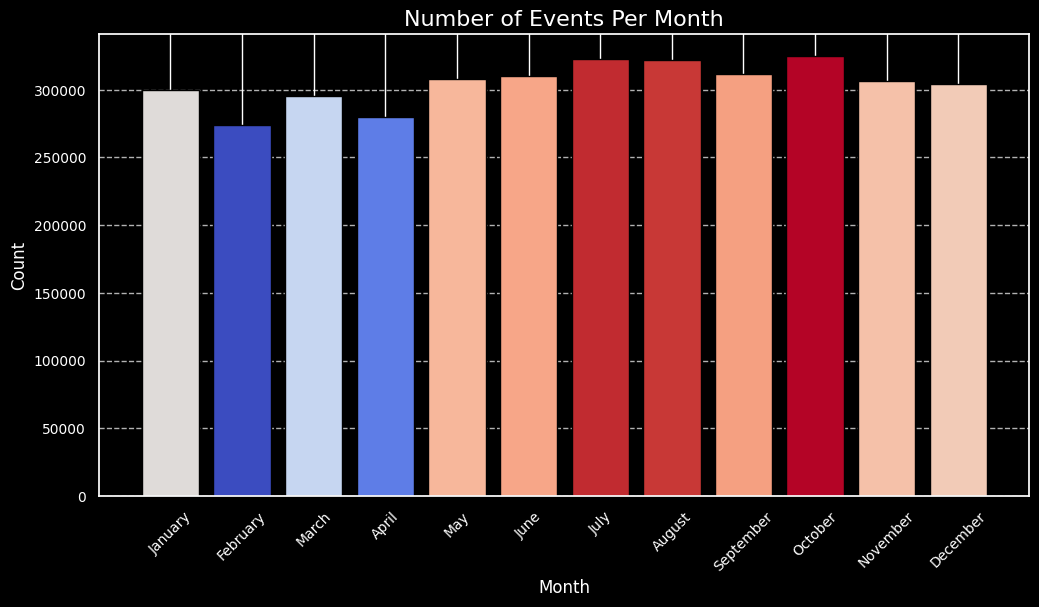

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

norm = plt.Normalize(pd_month_df["count"].min(), pd_month_df["count"].max())
colors = plt.cm.coolwarm(norm(pd_month_df["count"]))

# Set dark theme for plot
sns.set_theme(style="darkgrid")
plt.style.use('dark_background')

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(pd_month_df["month_name"], pd_month_df["count"], color=colors, edgecolor="black")

# Customize the plot
plt.xlabel("Month", color="white", fontsize=12)
plt.ylabel("Count", color="white", fontsize=12)
plt.title("Number of Events Per Month", color="white", fontsize=16)
plt.xticks(color="white", fontsize=10, rotation=45)
plt.yticks(color="white", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()
